In [1]:
# import libraries
import pandas as pd
import scipy.stats
import statsmodels.stats.multitest
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# disable warnings, use w caution
import warnings
warnings.filterwarnings('ignore')

# project specific libs
import os
import matplotlib.pyplot as plt
import pathlib

In [2]:
# project specific path
path = '/Users/KevinBu/Desktop/clemente_lab/Projects/oa/'

In [3]:
# from AC Q2 run of merged saliva stool
df_map = pd.read_csv(path + 'inputs/Qiime2_0/qiime_mapping_file.tsv', sep='\t', index_col=0)
q2_row = df_map.loc['#q2:types',:]
df_map = df_map.drop('#q2:types')

# change index so it matches metadata file
df_map.index = df_map.index.map(lambda x: x.split('.guma')[0])

# drop MOC and elution buffer
df_map = df_map.drop(['MOC.320','elutionbuffer.plate313'])

# grab metadata
df_meta = pd.read_csv(path + 'inputs/Metadata_OA.csv')

# rename 'Run_ID_Saliva' to be correct
df_meta['Timepoints'] = df_meta['Timepoints'].apply(lambda x: 'pre' if x == '0' else 'post')
df_meta['Patient_ID'] = df_meta['Patient_ID'].apply(lambda x: x[:-3])  
df_meta['Study_ID'] = df_meta['Study_ID'].apply(lambda x: x.split('_')[0][-3:]) 

# create per sample type mapping files
type_to_ST = {'saliva':'Saliva','stool':'fecal'}
type_to_df_map = {}

# split into specimen type
for t in type_to_ST:
    # subset on specimen type
    df_map_type = df_map[df_map['SpecimenType'] == type_to_ST[t]]

    # as to not overwrite df meta
    df_meta_type = df_meta.copy()

    # create new sample ID for specimen type and set as index
    df_meta_type['#SampleID'] = df_meta['Patient_ID'] + '-' + df_meta['Study_ID'] + '.' + df_meta['Timepoints'] + '.' + t
    df_meta_type = df_meta_type.set_index('#SampleID')

    # create full mapping file
    df_map_type = pd.concat([df_map_type, df_meta_type],axis=1)

    # use only sequenced samples
    df_map_type = df_map_type.dropna(how='any',subset='BarcodeSequence')

    # drop all na columns
    df_map_type = df_map_type.dropna(how='all',axis=1)

    # drop VAD OA 015 because misdx with PsA not OA
    if t == 'saliva':
        df_map_type = df_map_type.drop(['VAOAD-015.pre.saliva','VAOAD-015.post.saliva'])
    if t == 'stool':
        df_map_type = df_map_type.drop(['VAOAD-015.pre.stool','VAOAD-015.post.stool'])

    # populate dict of mapping files
    type_to_df_map[t] = df_map_type

    # export for q2
    df_q2_type = pd.concat([q2_row.to_frame().T, df_map_type])
    df_q2_type.index.name = '#SampleID'
    df_q2_type.iloc[0,:] = 'categorical'
    df_q2_type.to_csv(path + 'inputs/qiime_mapping_file_' + t + '.tsv', sep='\t')
    df_q2_type = df_q2_type[df_q2_type['Adherece_antiinflam'].isin(['Moderate adherence', 'High adherence','categorical'])]
    df_q2_type.to_csv(path + 'inputs/qiime_mapping_file_' + t + '_adh.tsv', sep='\t')
    df_q2_type = df_q2_type[df_q2_type['Adherece_antiinflam'].isin(['Moderate adherence', 'High adherence','categorical'])]
    df_q2_resp = df_q2_type[df_q2_type['WOMAC_P_Response'].isin(['categorical', 'Response'])]
    df_q2_resp.to_csv(path + 'inputs/qiime_mapping_file_' + t + '_adh_response.tsv', sep='\t')
    df_q2_nonresp = df_q2_type[df_q2_type['WOMAC_P_Response'].isin(['categorical', 'No response'])]
    df_q2_nonresp.to_csv(path + 'inputs/qiime_mapping_file_' + t + '_adh_noresponse.tsv', sep='\t')

type_to_df_map['stool'].head()

,BarcodeSequence,LinkerPrimerSequence,Separate,Timepoint,Together,ContactEmail,ContactName,PrimaryInvestigator,Cohort,RawDataNotes,...,broccoli,Garbanzo_beans,pork,beef,burger,Total_omega3,Adherence_omega3,Total_omega6,Adherence_omega6,Total_o3_o6
#SampleID,,,,,,,,,,,,,,,,,,,,,
OAD-001.pre.stool,TTCAGTTCGTTA,CCGGACTACHVGGGTWTCTAAT,All,pre,OAD-001.pre.stool.guma.plate313,rebecca.blank@nyulangone.org,Rebecca Blank,Jose Scher,NonVA,OAD-001.pre.stool.guma.plate313,...,0.0,0.0,0.0,0.0,0.0,NaN,Low adherence,NaN,Low adherence,0.0
OAD-001.post.stool,CGGCCAGAAGCA,CCGGACTACHVGGGTWTCTAAT,All,post,OAD-001.post.stool.guma.plate313,rebecca.blank@nyulangone.org,Rebecca Blank,Jose Scher,NonVA,OAD-001.post.stool.guma.plate313,...,4.0,0.0,0.0,0.0,0.0,48.0,Low adherence,72.0,Low adherence,131.0
OAD-003.pre.stool,GACGTTAAGAAT,CCGGACTACHVGGGTWTCTAAT,All,pre,OAD-003.pre.stool.guma.plate313,rebecca.blank@nyulangone.org,Rebecca Blank,Jose Scher,NonVA,OAD-003.pre.stool.guma.plate313,...,0.0,0.0,0.0,14.0,0.0,16.8,Low adherence,53.2,High adherence,75.0
OAD-003.post.stool,TCGCTACAGATG,CCGGACTACHVGGGTWTCTAAT,All,post,OAD-003.post.stool.guma.plate313,rebecca.blank@nyulangone.org,Rebecca Blank,Jose Scher,NonVA,OAD-003.post.stool.guma.plate313,...,4.0,0.0,0.0,0.0,0.0,48.0,Low adherence,108.0,High adherence,171.0
OAD-004.pre.stool,ATGGGACCTTCA,CCGGACTACHVGGGTWTCTAAT,All,pre,OAD-004.pre.stool.guma.plate313,rebecca.blank@nyulangone.org,Rebecca Blank,Jose Scher,NonVA,OAD-004.pre.stool.guma.plate313,...,2.8,0.0,0.0,0.0,0.0,2.8,Low adherence,28.0,Low adherence,35.8


In [4]:
###
# Hypothesis 1: There will be a measurable difference in WOMAC pain response scores and 
# other outcomes from baseline to after the dietary intervention.
###

# outcome variables
outcomes = ['VAS_Pt', 'VAS_overall', 'WOMAC_pain', 'WOMAC_stiffness', 'WOMAC_activity', 'WOMAC_total', 'Pain_DETECT', 
            'CES_D', 'Helplesness', 'Magnification', 'Rumination', 'PCS_EN', 'Sleep_distrubance', 'PASE_walk', 'PASE_light', 
            #'PASE_gardening', # Where did this go? gardening_improve is binary
            'BMI']


# hypothesis 1
# create a new df_meta
df_meta = pd.read_csv(path + 'inputs/Metadata_OA.csv')

# rename 'Run_ID_Saliva' to be correct
df_meta['Timepoints'] = df_meta['Timepoints'].apply(lambda x: 'pre' if x == '0' else 'post')
df_meta['Patient_ID'] = df_meta['Patient_ID'].apply(lambda x: x[:-3])  
df_meta['Study_ID'] = df_meta['Study_ID'].apply(lambda x: x.split('_')[0][-3:]) 
df_meta['#SampleID'] = df_meta['Patient_ID'] + '-' + df_meta['Study_ID'] + '.' + df_meta['Timepoints'] + '.stool'
df_meta = df_meta.set_index('#SampleID')

# convert % to floats for calculations down the road
bin = []
cont = []
df_paired_os = []
for w in outcomes:
    df_w = df_meta[w]
    if df_w.nunique() > 2: # do spearman
        df_meta[w] = df_meta[w].astype(str).str.replace('%','').astype(float).values
        cont.append(w)
    else:
        bin.append(w)

    # compute difference and store it
    df_md = df_meta.copy()
    df_md['SubjectID'] = df_md['Patient_ID'] + df_md['Study_ID']
    
    # first drop unpaired samples
    s_remove = []
    for s in list(df_md['SubjectID'].values):
        if len(df_md[df_md['SubjectID'] == s]) != 2:
            s_remove.append(s)
    df_md = df_md.loc[~df_md['SubjectID'].isin(s_remove),:] # careful not to use ([s_remove])
    
    # set vars
    group_var = 'Timepoints'
    pair_var = 'SubjectID'
    groups = ['pre','post']
    
    # get paired per indiv pair
    pair_to_diff = {}
    for p in list(df_md[pair_var].values):
        df = df_md[df_md[pair_var] == p]
        t0 = float(df[df[group_var] == groups[0]][w].values)
        tf = float(df[df[group_var] == groups[1]][w].values)
        pair_to_diff[p] = tf - t0
    
    df_paired_o = pd.DataFrame.from_dict(pair_to_diff, orient='index', columns=[w + '_diff'])
    df_paired_os.append(df_paired_o)

df_meta_paired = pd.concat([*df_paired_os], axis=1)    

print(bin)
print(cont)

# split into all and mod high only
a = 'modhigh'
job = 'jobs02'
df_meta = df_meta[df_meta['Adherece_antiinflam'].isin(['Moderate adherence', 'High adherence'])]
        
print(len(df_meta))

df_results = pd.DataFrame(columns=['var','effect','pval','stat'])
# do post treatment vals of binary vars differ from pre treatment 'unpaired'
for b in bin:
    ct_table_ind=pd.crosstab(df_meta["Timepoints"],df_meta[b])
    chi2_stat, p, dof, expected = scipy.stats.chi2_contingency(ct_table_ind)
    row=pd.DataFrame.from_dict({'var': [b],'effect':[chi2_stat],'pval':[p],'stat':['chi2']})
    df_results = pd.concat([df_results, row])

# fishers exact
for b in bin:
    ct_table_ind=pd.crosstab(df_meta["Timepoints"],df_meta[b])
    fisher, p = scipy.stats.fisher_exact(ct_table_ind)
    row=pd.DataFrame.from_dict({'var': [b],'effect':[t],'pval':[p],'stat':['fisher']})
    df_results = pd.concat([df_results, row])
    
# do post treatment vals of continuous vars differ from pre treatment unpaired
df_pre = df_meta[df_meta['Timepoints'] == 'pre']
df_post = df_meta[df_meta['Timepoints'] == 'post']
for c in cont:
    try:
        W,p = scipy.stats.mannwhitneyu(x=df_pre[c].values,y=df_post[c].values, nan_policy='omit')
    except:
        W,p = 0, 1
    row=pd.DataFrame.from_dict({'var': [c],'effect':[W],'pval':[p],'stat':['mwu']})
    if p < 0.05:
        ax = sns.boxplot(data=df_meta, x='Timepoints', y=c, orient='v')
        sns.swarmplot(data=df_meta, x='Timepoints', y=c, palette='dark:grey', hue=None, orient='v')
    
        # ax.axes.set_title("Title",fontsize=48)
        ax.set_ylabel(c,fontsize=16)
        ax.set_xlabel('Timepoints',fontsize=16)                
        ax.tick_params(labelsize=16)
        sns.despine()
        plt.tight_layout()
        plt.savefig(path + 'outputs/' + job + '/mwu_' + c  + '.pdf')
        plt.close()            
    row=pd.DataFrame.from_dict({'var': [c],'effect':[W],'pval':[p],'stat':['MWU']})
    df_results = pd.concat([df_results, row])
    
df_pre = df_meta[df_meta['Timepoints'] == 'pre']
df_post = df_meta[df_meta['Timepoints'] == 'post']
for c in cont:
    t,p = scipy.stats.ttest_ind(a=df_pre[c].values,b=df_post[c].values, nan_policy='omit')
    row=pd.DataFrame.from_dict({'var': [c],'effect':[t],'pval':[p],'stat':['ttest']})
    if p < 0.05:
        ax = sns.boxplot(data=df_meta, x='Timepoints', y=c, orient='v')
        sns.swarmplot(data=df_meta, x='Timepoints', y=c, palette='dark:grey', hue=None, orient='v')
    
        # ax.axes.set_title("Title",fontsize=48)
        ax.set_ylabel(c,fontsize=16)
        ax.set_xlabel('Timepoints',fontsize=16)                
        ax.tick_params(labelsize=16)
        sns.despine()
        plt.tight_layout()
        plt.savefig(path + 'outputs/' + job + '/tt_' + c  + '.pdf')
        plt.close()            
    row=pd.DataFrame.from_dict({'var': [c],'effect':[t],'pval':[p],'stat':['ttest']})
    df_results = pd.concat([df_results, row])

# unpaired and then paired
df_pre = df_meta[df_meta['Timepoints'] == 'pre']
df_post = df_meta[df_meta['Timepoints'] == 'post']
for c in cont:
    W,p = scipy.stats.wilcoxon(x=df_pre[c].values,y=df_post[c].values, nan_policy='omit')
    row=pd.DataFrame.from_dict({'var': [c],'effect':[W],'pval':[p],'stat':['WSR']})
    if p < 0.05:
        ax = sns.boxplot(data=df_meta, x='Timepoints', y=c, orient='v')
        sns.swarmplot(data=df_meta, x='Timepoints', y=c, palette='dark:grey', hue=None, orient='v')
    
        # ax.axes.set_title("Title",fontsize=48)
        ax.set_ylabel(c,fontsize=16)
        ax.set_xlabel('Timepoints',fontsize=16)                
        ax.tick_params(labelsize=16)
        sns.despine()
        plt.tight_layout()
        plt.savefig(path + 'outputs/' + job + '/wsr_' + c  + '.pdf')
        plt.close()            
    row=pd.DataFrame.from_dict({'var': [c],'effect':[W],'pval':[p],'stat':['WSR']})
    df_results = pd.concat([df_results, row])

df_pre = df_meta[df_meta['Timepoints'] == 'pre']
df_post = df_meta[df_meta['Timepoints'] == 'post']
for c in cont:
    t,p = scipy.stats.ttest_rel(a=df_pre[c].values,b=df_post[c].values, nan_policy='omit')
    row=pd.DataFrame.from_dict({'var': [c],'effect':[W],'pval':[p],'stat':['pairedt']})
    if p < 0.05:
        ax = sns.boxplot(data=df_meta, x='Timepoints', y=c, orient='v')
        sns.swarmplot(data=df_meta, x='Timepoints', y=c, palette='dark:grey', hue=None, orient='v')
    
        # ax.axes.set_title("Title",fontsize=48)
        ax.set_ylabel(c,fontsize=16)
        ax.set_xlabel('Timepoints',fontsize=16)                
        ax.tick_params(labelsize=16)
        sns.despine()
        plt.tight_layout()
        plt.savefig(path + 'outputs/' + job + '/pairedt_' + c  + '.pdf')
        plt.close()          
    row=pd.DataFrame.from_dict({'var': [c],'effect':[t],'pval':[p],'stat':['pairedt']})
    df_results = pd.concat([df_results, row])

df_results.to_csv(path + 'outputs/' + job + '/outcome_testing.tsv', sep='\t')
df_results.head()
    

[]
['VAS_Pt', 'VAS_overall', 'WOMAC_pain', 'WOMAC_stiffness', 'WOMAC_activity', 'WOMAC_total', 'Pain_DETECT', 'CES_D', 'Helplesness', 'Magnification', 'Rumination', 'PCS_EN', 'Sleep_distrubance', 'PASE_walk', 'PASE_light', 'BMI']
32


,var,effect,pval,stat
0,VAS_Pt,198.5,0.008316,MWU
0,VAS_overall,168.5,0.131314,MWU
0,WOMAC_pain,170.0,0.017900,MWU
0,WOMAC_stiffness,172.5,0.013052,MWU
0,WOMAC_activity,164.5,0.032592,MWU


In [5]:
###
# Hypothesis 2: There will be an association between oral and gut microbiome and pain outcomes
###
# construct alpha, beta and paired alpha dataframes
g_to_dfd = {}
# g_test = ['stool','saliva_adh', 'stool_adh', 'saliva']
g_test = ['saliva_adh', 'stool_adh']

for g in g_test:
    # maps diversity type to dataframe
    g_to_dfd[g] = {}

    # get alpha diversities
    df_alpha = pd.read_csv(path + 'outputs/Qiime2_' + g + '/metadata.tsv', sep='\t', index_col=0)
    df_alpha = df_alpha.drop('#q2:types')
    df_alpha['SubjectID'] = df_alpha['Patient_ID'] + df_alpha['Study_ID']
    df_alpha = df_alpha[['SubjectID', 'Timepoints', 'shannon_entropy']]
    g_to_dfd[g]['alpha'] = df_alpha

    # get paired alpha div, first drop unpaired samples
    s_remove = []
    for s in list(df_alpha['SubjectID'].values):
        if len(df_alpha[df_alpha['SubjectID'] == s]) != 2:
            s_remove.append(s)
    df_alpha = df_alpha.loc[~df_alpha['SubjectID'].isin(s_remove),:] # careful not to use ([s_remove])
    
    # set vars
    alpha_metric = 'shannon_entropy'
    group_var = 'Timepoints'
    pair_var = 'SubjectID'
    groups = ['pre','post']
    
    # get paired per indiv pair
    pair_to_diff = {}
    for p in list(df_alpha[pair_var].values):
        df = df_alpha[df_alpha[pair_var] == p]
        alpha_0 = float(df[df[group_var] == groups[0]][alpha_metric].values)
        alpha_1 = float(df[df[group_var] == groups[1]][alpha_metric].values)
        pair_to_diff[p] = alpha_1 - alpha_0
    
    df_paired_alpha = pd.DataFrame.from_dict(pair_to_diff, orient='index', columns=[alpha_metric + '_diff'])
    g_to_dfd[g]['paired_alpha'] = df_paired_alpha

    # get beta div
    df_beta = pd.read_csv(path + 'outputs/Qiime2_' + g + '/core_metrics_results/distance-matrix.tsv',
                              sep='\t', index_col=0)
        
    # grab twin to pair dict
    pair_to_ids = {}
    for p in list(df_alpha[pair_var].values):
        df = df_alpha[df_alpha[pair_var] == p]
        id_0 = str(df[df[group_var] == groups[0]].index.values[0])
        id_1 = str(df[df[group_var] == groups[1]].index.values[0])
        pair_to_ids[p] = (id_0, id_1)
    
    # get distances for each twin pair per beta div matrix    
    pair_to_dist = {}
    for p in list(df_alpha[pair_var].values):
        id_0, id_1 = pair_to_ids[p]
        pair_to_dist[p] = df_beta.loc[id_0, id_1]
    
    df_paired_beta = pd.DataFrame.from_dict(pair_to_dist, orient='index', columns=['Unweighted_Unifrac'])
    g_to_dfd[g]['paired_beta'] = df_paired_beta

g_to_dfd['stool_adh']['paired_beta'].head()

,Unweighted_Unifrac
OAD001,0.6672
OAD003,0.2837
OAD004,0.4237
OAD005,0.3257
OAD006,0.1022


In [6]:
# Testing for each sample type for (1) all and (2) high adh only
# (A) Chisq of quartiles with adherence 
# (B) MWU/TT unpaired of outcomes against distance

def chisq_of_df_cols(df, c1, c2):
    groupsizes = df.groupby([c1, c2]).size()
    ctsum = groupsizes.unstack(c1)
    # fillna(0) is necessary to remove any NAs which will cause exceptions
    return(scipy.stats.chi2_contingency(ctsum.fillna(0)))

d_to_metric = {
    'alpha': 'shannon_entropy',
}
group_var = 'Adherece_antiinflam'

dfd_to_merge = {}
g_test = ['saliva_adh', 'stool_adh']

for g in g_test:
    dfd_to_merge[g] = {}

gs = []
ds = []
os = []
stats = []
ts = []
ps = []

arr = [gs,ds,os,stats,ts,ps]

def append_results(arr, val):
    for a,v in zip(arr,val):
        a.append(v)
    return arr

# for each sample type, grab relevant mapping file
# g_test = saliva, saliva_adh, stool, etc.
for g in g_test:
    for d in d_to_metric:
        # grab relevant diversity df
        df_div = g_to_dfd[g][d]

        if d == 'alpha':
            # df_div = df_div[df_div['Timepoints'] == 'pre']
            # df_div = df_div.set_index('SubjectID').drop('Timepoints',axis=1)
            # df_div = df_div.set_index('SubjectID').drop('Timepoints',axis=1)
            df_div['shannon_entropy'] = df_div['shannon_entropy'].astype(float)

        # merge with df of metadata var        
        # grab relevant sample IDs
        # g = saliva_adh
        idx = 'Run_ID_' + g.split('_')[0].capitalize()
        df_meta_sub = df_meta.dropna(subset=idx)
        df_meta_sub = df_meta_sub.set_index(idx)
        df_merge = pd.concat([df_meta_sub,df_div],axis=1)

        # subset on adh only
        df_merge = df_merge[df_merge[group_var].isin(['Moderate adherence', 'High adherence'])]

        # test association of div with outcomes
        for o in ['WOMAC_P_Response']: #  outcomes:                    
            # test association of adherence with pain outcomes
            div_metric = d_to_metric[d]
            x,p,dof,ef = chisq_of_df_cols(df_merge, group_var, o)
            arr = append_results(arr, ['metadata',group_var,o,'chisq',x,p])
            
            ax = sns.boxplot(data=df_merge, x=o, y=div_metric)
            sns.swarmplot(data=df_merge, x=o, y=div_metric, palette='dark:grey')
            sns.despine()
        
            plt.tight_layout()
            plt.savefig(path + 'outputs/jobs06/rvnr_nondiff_' + g + '_' + o + '_' + d + '.pdf')
            plt.close()          
        
            u, p = scipy.stats.mannwhitneyu(df_merge[df_merge[o] == 'Response'][div_metric].values, 
                                            df_merge[df_merge[o] == 'No response'][div_metric].values, 
                                            nan_policy='omit')

            arr = append_results(arr, [g,d,o,'mwu',t,p])

            t, p = scipy.stats.ttest_ind(df_merge[df_merge[o] == 'Response'][div_metric].values, 
                                            df_merge[df_merge[o] == 'No response'][div_metric].values, 
                                            nan_policy='omit')

            arr = append_results(arr, [g,d,o,'tt',t,p])

        # save results
        dfd_to_merge[g][d] = df_merge

        # export to Q2
        # df_q2_type = df_merge.set_index(['Together'])
        df_q2_type = df_merge.copy()
        q2_row = pd.Series(data=['categorical' for i in range(len(df_merge.columns))], 
                           index=list(df_merge.columns.values), dtype=str, name='#q2:types')
        df_q2_type = pd.concat([q2_row.to_frame().T, df_q2_type])
        df_q2_type.index.name = '#SampleID'
        df_q2_type.index = df_q2_type.index.map(lambda x: x.split('.guma')[0])
        # df_q2_type.to_csv(path + 'inputs/qiime_mapping_file_' + d + '_' + g + 'aggregate_outcomes.tsv', sep='\t')

df_results = pd.DataFrame.from_dict({
    'group': gs,
    'div': ds,
    'outcome': os,
    'statistic': stats,
    'test_stat': ts,
    'pval': ps
})
# df_results.to_csv(path + 'outputs/df_results_aggregate.tsv', sep='\t')
# df_results.head()
# df_results[df_results['pval'] < 0.05]
df_results

,group,div,outcome,statistic,test_stat,pval
0,metadata,Adherece_antiinflam,WOMAC_P_Response,chisq,0.232031,0.630022
1,saliva_adh,alpha,WOMAC_P_Response,mwu,1.153857,0.788413
2,saliva_adh,alpha,WOMAC_P_Response,tt,0.756449,0.456450
3,metadata,Adherece_antiinflam,WOMAC_P_Response,chisq,0.232031,0.630022
4,stool_adh,alpha,WOMAC_P_Response,mwu,0.756449,0.980536
5,stool_adh,alpha,WOMAC_P_Response,tt,0.182238,0.856866


In [7]:
# expand previous to all data, paired and unpaired diversities
d_to_metric = {
    'pre_alpha': 'shannon_entropy',
    'post_alpha': 'shannon_entropy',
    'paired_alpha': 'shannon_entropy_diff',
    'paired_beta': 'Unweighted_Unifrac',
}
group_var = 'Adherece_antiinflam'

dfd_to_merge = {}
g_test = ['stool_adh','saliva_adh']
for g in g_test:
    dfd_to_merge[g] = {}

gs = []
ds = []
os = []
stats = []
ts = []
ps = []

arr = [gs,ds,os,stats,ts,ps]

def append_results(arr, val):
    for a,v in zip(arr,val):
        a.append(v)
    return arr

# for each sample type, grab relevant mapping file
# g_test = saliva, saliva_adh, stool, etc.
d_to_map = {}

for g in g_test:
    # drop duplicates so you have sample mapping to adh
    df_map_sub = type_to_df_map[g.split('_')[0]]
    df_map_sub.index = df_map_sub.index.map(lambda x: x.split('.')[0].replace('-',''))
    df_map_sub = df_map_sub.dropna(how='any',subset=group_var,axis=0)           
    
    # figure out which samples to keep
    # i.e. samples that have a pre and post time point
    keep = []
    for i in list(df_map_sub.index.values):
        if len(df_map_sub.loc[i,:]) == 2:
            keep.append(i)

    # get unique entires in sorted order
    # at this point we are only concerned with differences in values, 
    # as we've dropped samples with only one endpoint val
    save = []
    [save.append(x) for x in keep if x not in save]
    df_map_sub = df_map_sub.loc[save,:]

    # this double populates as OAD001 is an index twice, so the diff fills to both the pre and post col
    for o in outcomes:
        df_map_sub[o + '_diff'] = df_map_sub[df_map_sub['Timepoint'] == 'post'][o] - df_map_sub[df_map_sub['Timepoint'] == 'pre'][o] 

    # here we keep only the pre, but everything is identical b/w pre and post
    df_dropdup = df_map_sub[~df_map_sub.index.duplicated(keep='first')]
    d_to_map[g] = df_dropdup
    
    for d in d_to_metric:
        # grab relevant diversity df
        if d == 'pre_alpha' or d == 'post_alpha':
            df_div = g_to_dfd[g]['alpha']
        else:
            df_div = g_to_dfd[g][d]
        div_metric = d_to_metric[d]

        # when associating alpha div vs outcomes, look at if starting adiv predicts outcome
        if d == 'pre_alpha':
            df_div = df_div[df_div['Timepoints'] == 'pre']
            df_div = df_div.set_index('SubjectID').drop('Timepoints',axis=1)
            df_div = df_div.astype(float)

        if d == 'post_alpha':
            df_div = df_div[df_div['Timepoints'] == 'post']
            df_div = df_div.set_index('SubjectID').drop('Timepoints',axis=1)
            df_div = df_div.astype(float)

        # merge with df of metadata var        
        df_merge = pd.concat([df_dropdup,df_div],axis=1)

        # drop na in barcodes if samples not sequenced both pre and post
        df_merge = df_merge.dropna(how='any',subset='BarcodeSequence')
        
        # test association of div with outcomes
        for o in ['WOMAC_P_Response']:                     
            # test association of adherence with pain outcomes            
            ax = sns.boxplot(data=df_merge, y=o, x=div_metric)
            sns.swarmplot(data=df_merge, y=o, x=div_metric, palette='dark:grey')
            sns.despine()
        
            plt.tight_layout()
            plt.savefig(path + 'outputs/jobs06/WOMAC_barplot_' + g + '_' + o + '_' + d + '.pdf')
            plt.close()          

            # MWU and ttest
            u, p = scipy.stats.mannwhitneyu(df_merge[df_merge[o] == 'Response'][div_metric].values, 
                                            df_merge[df_merge[o] == 'No response'][div_metric].values, 
                                            nan_policy='omit')

            arr = append_results(arr, [g,d,o,'mwu',t,p])

            t, p = scipy.stats.ttest_ind(df_merge[df_merge[o] == 'Response'][div_metric].values, 
                                            df_merge[df_merge[o] == 'No response'][div_metric].values, 
                                            nan_policy='omit')

            arr = append_results(arr, [g,d,o,'tt',t,p])
         
        # save results
        dfd_to_merge[g][d] = df_merge

        # export to Q2
        df_q2_type = df_merge.set_index(['Together'])
        q2_row = pd.Series(data=['categorical' for i in range(len(df_merge.columns))], 
                           index=list(df_merge.columns.values), dtype=str, name='#q2:types')
        df_q2_type = pd.concat([q2_row.to_frame().T, df_q2_type])
        df_q2_type.index.name = '#SampleID'
        df_q2_type.index = df_q2_type.index.map(lambda x: x.split('.guma')[0])
        # df_q2_type.to_csv(path + 'inputs/qiime_mapping_file_' + d + '_' + g + '_outcomes.tsv', sep='\t')

df_results = pd.DataFrame.from_dict({
    'group': gs,
    'div': ds,
    'outcome': os,
    'statistic': stats,
    'test_stat': ts,
    'pval': ps
})
# df_results.to_csv(path + 'outputs/df_results_diff.tsv', sep='\t')

# df_results.head()
# the div==alpha results test whether pre-alpha div state associates with pain outcome changes (differences) quartiles
# the div==paired_alpha and paired_beta test whether the alpha and betas change in a similar way with the pain outcome
print(len(df_results[df_results['pval'] < 0.05]))
df_results


0


,group,div,outcome,statistic,test_stat,pval
0,stool_adh,pre_alpha,WOMAC_P_Response,mwu,0.182238,0.343434
1,stool_adh,pre_alpha,WOMAC_P_Response,tt,-0.594256,0.565542
2,stool_adh,post_alpha,WOMAC_P_Response,mwu,-0.594256,0.638889
3,stool_adh,post_alpha,WOMAC_P_Response,tt,0.769556,0.459355
4,stool_adh,paired_alpha,WOMAC_P_Response,mwu,0.769556,0.431818
5,stool_adh,paired_alpha,WOMAC_P_Response,tt,1.289488,0.226254
6,stool_adh,paired_beta,WOMAC_P_Response,mwu,1.289488,0.876263
7,stool_adh,paired_beta,WOMAC_P_Response,tt,-1.033580,0.325681
8,saliva_adh,pre_alpha,WOMAC_P_Response,mwu,-1.033580,0.755051
9,saliva_adh,pre_alpha,WOMAC_P_Response,tt,0.565329,0.584310


In [8]:
# test if the differences in diversity are significantly different from 0 for paired alpha
for g in g_test:
    print(g)
    for d in ['paired_alpha']:
        df_div = g_to_dfd[g][d] 
        df_map = d_to_map[g]

        df_merge = pd.concat([df_div, df_map], axis=1)
        for o in ['Response', 'No response']:
            df = df_merge[df_merge['WOMAC_P_Response'] == o]
            print(o)
            print(scipy.stats.wilcoxon(df['shannon_entropy_diff'], nan_policy='omit'))
df


stool_adh
Response
WilcoxonResult(statistic=4.0, pvalue=0.109375)
No response
WilcoxonResult(statistic=7.0, pvalue=1.0)
saliva_adh
Response
WilcoxonResult(statistic=9.0, pvalue=0.46875)
No response
WilcoxonResult(statistic=5.0, pvalue=0.625)


,shannon_entropy_diff,BarcodeSequence,LinkerPrimerSequence,Separate,Timepoint,Together,ContactEmail,ContactName,PrimaryInvestigator,Cohort,...,Pain_DETECT_diff,CES_D_diff,Helplesness_diff,Magnification_diff,Rumination_diff,PCS_EN_diff,Sleep_distrubance_diff,PASE_walk_diff,PASE_light_diff,BMI_diff
OAD001,-0.116436,AGGACAAACTAT,CCGGACTACHVGGGTWTCTAAT,Text,pre,OAD-001.pre.saliva,rebecca.blank@nyulangone.org,Rebecca Blank,Jose Scher,NonVA,...,-2.0,-1.0,-2.5,5.5,1.0,4.0,9.0,11.51,14.29,NaN
OAD003,-0.327749,TCTTCCTAAAGT,CCGGACTACHVGGGTWTCTAAT,All,pre,OAD-003.pre.saliva,rebecca.blank@nyulangone.org,Rebecca Blank,Jose Scher,NonVA,...,-4.5,1.0,-1.0,-1.0,-2.0,-5.5,-14.0,0.00,0.00,NaN
OAD004,0.866474,CTTGTGCGACAA,CCGGACTACHVGGGTWTCTAAT,All,pre,OAD-004.pre.saliva,rebecca.blank@nyulangone.org,Rebecca Blank,Jose Scher,NonVA,...,-1.0,3.0,-1.0,-1.0,-1.0,-3.0,0.0,0.00,0.00,3.264032
VAOAD001,0.007278,CTTACACTGCTT,CCGGACTACHVGGGTWTCTAAT,All,pre,VAOAD-001.pre.saliva,rebecca.blank@nyulangone.org,Rebecca Blank,Jose Scher,VA,...,-0.5,5.5,0.0,0.0,0.0,0.0,-2.5,0.00,0.00,-0.081446
VAOAD012,0.535614,GCGTGGTCATTA,CCGGACTACHVGGGTWTCTAAT,All,pre,VAOAD-012.pre.saliva,rebecca.blank@nyulangone.org,Rebecca Blank,Jose Scher,VA,...,-1.5,0.0,2.0,-2.0,-0.5,-0.5,-1.5,0.00,6.72,-1.072664
VAOAD009,NaN,TTGGACGTCCAC,CCGGACTACHVGGGTWTCTAAT,All,pre,VAOAD-009.pre.saliva,rebecca.blank@nyulangone.org,Rebecca Blank,Jose Scher,VA,...,-4.0,2.0,1.0,0.0,0.5,1.5,2.5,0.00,0.00,-0.139974


In [9]:
# Alpha div paired
# paired beta, comparing intra-indiv difference pre_post to inter pre and inter post
g_test = ['stool_adh','saliva_adh']
subgroups = ['All', 'Response', 'No response']

for g in g_test: #subgroups:
    print(g)
    df_a = pd.read_csv(path + 'outputs/Qiime2_' + g + '/metadata.tsv', sep='\t', index_col=0)
    df_a = df_a.drop('#q2:types')

    for sg in subgroups:
        print(sg)
        if sg == 'All':
            df_alpha = df_a.copy()
        else:
            df_alpha = df_a[df_a['WOMAC_P_Response'] == sg]
        
        df_alpha['SubjectID'] = df_alpha['Patient_ID'] + df_alpha['Study_ID']
        df_alpha = df_alpha[['SubjectID', 'Timepoints', 'shannon_entropy']]
        
        # drop unpaired samples
        s_remove = []
        for s in list(df_alpha['SubjectID'].values):
            if len(df_alpha[df_alpha['SubjectID'] == s]) != 2:
                s_remove.append(s)
        df_alpha = df_alpha.loc[~df_alpha['SubjectID'].isin(s_remove),:] # careful not to use ([s_remove])
        
        # set vars
        alpha_metric = 'shannon_entropy'
        group_var = 'Timepoints'
        pair_var = 'SubjectID'
        groups = ['pre','post']
        
        # get paired per indiv pair
        pair_to_diff = {}
        for p in list(df_alpha[pair_var].values):
            df = df_alpha[df_alpha[pair_var] == p]
            alpha_0 = float(df[df[group_var] == groups[0]][alpha_metric].values)
            alpha_1 = float(df[df[group_var] == groups[1]][alpha_metric].values)
            pair_to_diff[p] = alpha_0 - alpha_1
        
        df_paired_alpha = pd.DataFrame.from_dict(pair_to_diff, orient='index', columns=[alpha_metric + '_diff'])
        
        # one-sided t-test, n.s.; RA-UA values 
        # t, p = scipy.stats.ttest_1samp(df_paired_alpha[alpha_metric + '_diff'],popmean=0)
    
        print('paired alpha wilcoxon')
        s, p = scipy.stats.wilcoxon(df_paired_alpha[alpha_metric + '_diff'])
        print(s, p)
        
        # separate
        df_alpha[alpha_metric] = df_alpha[alpha_metric].map(lambda x: float(x))
        ax = sns.boxplot(data=df_alpha, x=group_var, y=alpha_metric)
        sns.swarmplot(data=df_alpha, x=group_var, y=alpha_metric, palette='dark:grey')
        sns.despine()
    
        plt.tight_layout()
        plt.savefig(path + 'outputs/Qiime2_' + g + '/' + sg + '_alpha.pdf')
        plt.close()          
    
        # now do beta
        df_beta = pd.read_csv(path + 'outputs/Qiime2_' + g + '/core_metrics_results/distance-matrix.tsv',
                              sep='\t', index_col=0)
        
        # set vars
        alpha_metric = 'shannon_entropy'
        group_var = 'Timepoints'
        pair_var = 'SubjectID'
        groups = ['pre','post']
        g0, g1 = groups[0], groups[1]
        
        # grab twin to pair dict
        pair_to_ids = {}
        for p in list(df_alpha[pair_var].values):
            df = df_alpha[df_alpha[pair_var] == p]
            id_0 = str(df[df[group_var] == g0].index.values[0])
            id_1 = str(df[df[group_var] == g1].index.values[0])
            pair_to_ids[p] = (id_0, id_1)
        
        # get distances for each twin pair per beta div matrix    
        pair_to_dist = {}
        for p in list(df_alpha[pair_var].values):
            id_0, id_1 = pair_to_ids[p]
            pair_to_dist[p] = df_beta.loc[id_0, id_1]
        
        df_paired_beta = pd.DataFrame.from_dict(pair_to_dist, orient='index', columns=['Unweighted_Unifrac'])
        
        # grab inter RA distances
        # this is from unweighted_Timepoint_significance.qzv -> download as tsv
        df_raw = pd.read_csv(path + 'outputs/Qiime2_' + g + '/raw_data.tsv', 
                             sep='\t', index_col=0)
        df_0 = df_raw[df_raw['Group1'] == g0]
        df_0 = df_0[df_0['Group2'] == g0]
        df_1 = df_raw[df_raw['Group1'] == g1]
        df_1 = df_1[df_1['Group2'] == g1]
        
        # compare distances
        inter_twin = df_paired_beta['Unweighted_Unifrac'].values
        inter_0 = df_0['Distance'].values
        inter_1 = df_1['Distance'].values
        
        u, p = scipy.stats.mannwhitneyu(inter_twin, inter_0)
        #print(u, p)
        
        t, p = scipy.stats.ttest_ind(inter_twin, inter_1)
        #print(t, p)
        
        t, p = scipy.stats.ttest_ind(inter_0, inter_1)
        # print(t, p)
        
        f, p = scipy.stats.f_oneway(inter_0, inter_1, inter_twin)
        # print('inter intra anova')
        p# rint(f, p)
        
        category = ['intra_twin_pair']*len(inter_twin) + ['inter_' + g0 + '_only']*len(inter_0) + ['inter_' + g1 + '_only']*len(inter_1)
        distances = list(inter_twin) + list(inter_0) + list(inter_1)
        df_dist = pd.DataFrame(data=np.array([category,distances]).T, columns=['category','distance'])
        df_dist['distance'] = df_dist['distance'].astype(float)
        df_dist.to_csv(path + 'outputs/Qiime2_' + g + '/' + sg + '_inter_intra_beta_dist.tsv',sep='\t')
                             
        sns.boxplot(data=df_dist, x='category', y='distance')
        sns.swarmplot(data=df_dist, x='category', y='distance', color='black')
        sns.despine()
    
        plt.tight_layout()
        plt.savefig(path + 'outputs/Qiime2_' + g + '/' + sg + '_beta.pdf')
        plt.close()          

stool_adh
All
paired alpha wilcoxon
33.0 0.414306640625
Response
paired alpha wilcoxon
4.0 0.109375
No response
paired alpha wilcoxon
7.0 1.0
saliva_adh
All
paired alpha wilcoxon
26.0 0.19091796875
Response
paired alpha wilcoxon
9.0 0.46875
No response
paired alpha wilcoxon
5.0 0.625


In [10]:
# specific taxa profiling
GL_to_otu = {}

groups = ['saliva_adh', 'stool_adh']
levels = ['6','7']
for g in groups:
    GL_to_otu[g] = {}
    for l in levels:
        # read in csv
        df_otu = pd.read_csv(path + 'outputs/Qiime2_' + g + '/level-' + l + '.csv', index_col=0)

        # filter on OTU only 
        keep = []
        for x in df_otu.columns:
            if 'd__' in x:
                keep.append(x)
        df_otu = df_otu.loc[:,keep]

        # normalize by dividing by row sum
        df_otu = df_otu.div(df_otu.sum(axis=1),axis=0)

        # save to dict
        GL_to_otu[g]['L' + l] = df_otu

                                       
GL_to_otu['stool_adh']['L6'].head()

,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Phocaeicola_A_858004,d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Oscillospirales;f__Ruminococcaceae;g__Faecalibacterium,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Prevotella,d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Lachnospirales;f__Lachnospiraceae;g__Agathobacter_164117,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides_H,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Muribaculaceae;g__Paramuribaculum,d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Oscillospirales;f__Ruminococcaceae;g__Gemmiger_A_73129,d__Bacteria;p__Firmicutes_D;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus,d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Lachnospirales;f__Lachnospiraceae;g__Acetatifactor,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Rikenellaceae;g__Alistipes_A_871400,...,d__Bacteria;p__Firmicutes_A;__;__;__;__,d__Bacteria;p__Actinobacteriota;c__Actinomycetia;o__Actinomycetales;f__Micrococcaceae;g__Nesterenkonia,d__Bacteria;p__Firmicutes_D;c__Bacilli;o__Lactobacillales;__;__,d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Peptostreptococcales;f__Anaerovoracaceae;g__S5-A14a,d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Clostridiales;f__Clostridiaceae_222000;__,d__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Azospirillales_507929;f__Azospirillaceae_507917;g__Azospirillum,d__Bacteria;p__Firmicutes_D;c__Bacilli;o__Erysipelotrichales;f__Coprobacillaceae;__,d__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Sphingomonas_L_486704,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Muribaculaceae;__,d__Bacteria;p__Actinobacteriota;__;__;__;__
index,,,,,,,,,,,,,,,,,,,,,
OAD-001.post.stool,0.014084,0.039046,0.022027,0.001515,0.173283,0.000000,0.021230,0.000160,0.152452,0.033001,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
OAD-001.pre.stool,0.022576,0.007098,0.005128,0.000000,0.292202,0.001994,0.013555,0.000000,0.000783,0.026849,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
OAD-003.post.stool,0.273829,0.067421,0.184572,0.026929,0.053673,0.037783,0.009619,0.023935,0.005789,0.012060,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
OAD-003.pre.stool,0.181156,0.067844,0.150895,0.063229,0.051360,0.055600,0.012363,0.051513,0.006045,0.025918,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
OAD-004.post.stool,0.174773,0.040785,0.000000,0.001855,0.124402,0.000000,0.001400,0.000371,0.014265,0.090594,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# Metabolome testing
gdt_to_df = {}
for g in ['saliva','stool']:
    gdt_to_df[g] = {}
    for d in ['paired_beta']: # just arbitrarily 
        gdt_to_df[g][d] = {}
        df_merge = dfd_to_merge[g + '_adh'][d]
        df_meta = pd.read_csv(path + 'inputs/' + g + '_normalized.csv')

        # split on timepoint
        for t in ['Baseline','After diet']:
            df = df_meta[df_meta['Time'] == t]
            df = df.set_index('Study_ID')
            df.index = df.index.map(lambda x: x.split('_')[0])
            df = df.drop('Time',axis=1)
            gdt_to_df[g][d][t] = df

        gdt_to_df[g][d]['diff'] = gdt_to_df[g][d]['After diet'] - gdt_to_df[g][d]['Baseline']

gdt_to_df[g][d][t].head()

,H_Pyridoxamine,H_Thiamine,H_Melezitose,H_Phosphocholine,H_SN_Glycero_3_Phophocholine,H_Gamma_Valerobetaine,H_N_Acetylneuraminic_acid,H_Pyridoxine,H_N_Acetylneuraminic_Acid,H_N_Acetylmuramic_Acid,...,H_Nonhydroxylated_bile_acid,H_Hydroxydodecanoic_acid,H_Omega_Hydroxydodecanoate,H_Delta_Methyldodecenoic_Acid,H_Hydroxydecanoic_acid,H_Hydroxydecanoate,H_Methylpentanoic_acid,H_Monohydroxylated_bile_acid,H_Palmitoyl_ethanolamide,H_Linoleic_Acid
Study_ID,,,,,,,,,,,,,,,,,,,,,
VAOAD001,0.312342,-0.312477,0.119853,-0.492876,-0.671376,-0.202952,0.203945,-0.455869,0.352628,0.151464,...,0.054336,-0.330037,-0.886045,-0.314427,-0.322677,-0.650357,-0.361695,0.132794,-0.067464,-0.112641
VAOAD009,0.000428,-0.481251,-0.179337,0.983217,0.167836,0.067823,0.364897,-0.371942,0.545435,-0.007664,...,-0.022614,-0.334936,-0.802118,-0.929470,-0.369578,-0.566431,0.075375,-0.519189,-0.180631,-0.418351
OAD001,-0.285212,-0.556445,-0.651325,0.357509,-0.401875,-0.295787,0.137736,-0.165902,0.112170,0.096791,...,-0.923477,-0.589028,-1.535141,-0.525277,-0.278312,-0.600484,0.019657,-0.576831,-0.901479,-1.089906
VAOAD004,0.140904,1.089055,-0.668077,-1.061336,-0.370602,-0.329379,-0.654931,0.142971,-1.006689,-0.100373,...,-0.354297,0.449897,0.489189,0.413723,0.474250,0.661963,0.245553,0.279290,-0.444319,-0.912164
VAOAD011,-0.346855,1.028262,-0.450323,-0.025939,-0.223029,-0.766374,-0.538410,-1.091423,-0.328522,-0.524686,...,-0.385428,0.419748,0.429119,0.333756,0.448461,0.598846,0.390035,0.287682,-0.532141,-0.752280


In [12]:
# Metabolome testing
gt_to_meta = {}
for g in ['saliva','stool']:
    gt_to_meta[g] = {}
    df_meta = pd.read_csv(path + 'inputs/' + g + '_normalized.csv')

    # split on timepoint
    for t in ['Baseline','After diet']:
        df = df_meta[df_meta['Time'] == t]
        df = df.set_index('Study_ID')
        df.index = df.index.map(lambda x: x.split('_')[0])
        df = df.drop('Time',axis=1)
        gt_to_meta[g][t] = df

    pre_df = gt_to_meta[g]['Baseline'].copy()
    pre_df.index = pre_df.index.map(lambda x: x.replace('D0','D-0'))
    pre_df.index = pre_df.index.map(lambda x: x + '.pre.' + g)
    post_df = gt_to_meta[g]['After diet'].copy()
    post_df.index = post_df.index.map(lambda x: x.replace('D0','D-0'))
    post_df.index = post_df.index.map(lambda x: x + '.post.' + g)
    
    gt_to_meta[g]['diff'] = gt_to_meta[g]['After diet'] - gt_to_meta[g]['Baseline']
    gt_to_meta[g]['all'] = pd.concat([pre_df,post_df])
    

gt_to_meta[g][t].head()

,H_Pyridoxamine,H_Thiamine,H_Melezitose,H_Phosphocholine,H_SN_Glycero_3_Phophocholine,H_Gamma_Valerobetaine,H_N_Acetylneuraminic_acid,H_Pyridoxine,H_N_Acetylneuraminic_Acid,H_N_Acetylmuramic_Acid,...,H_Nonhydroxylated_bile_acid,H_Hydroxydodecanoic_acid,H_Omega_Hydroxydodecanoate,H_Delta_Methyldodecenoic_Acid,H_Hydroxydecanoic_acid,H_Hydroxydecanoate,H_Methylpentanoic_acid,H_Monohydroxylated_bile_acid,H_Palmitoyl_ethanolamide,H_Linoleic_Acid
Study_ID,,,,,,,,,,,,,,,,,,,,,
VAOAD001,0.312342,-0.312477,0.119853,-0.492876,-0.671376,-0.202952,0.203945,-0.455869,0.352628,0.151464,...,0.054336,-0.330037,-0.886045,-0.314427,-0.322677,-0.650357,-0.361695,0.132794,-0.067464,-0.112641
VAOAD009,0.000428,-0.481251,-0.179337,0.983217,0.167836,0.067823,0.364897,-0.371942,0.545435,-0.007664,...,-0.022614,-0.334936,-0.802118,-0.929470,-0.369578,-0.566431,0.075375,-0.519189,-0.180631,-0.418351
OAD001,-0.285212,-0.556445,-0.651325,0.357509,-0.401875,-0.295787,0.137736,-0.165902,0.112170,0.096791,...,-0.923477,-0.589028,-1.535141,-0.525277,-0.278312,-0.600484,0.019657,-0.576831,-0.901479,-1.089906
VAOAD004,0.140904,1.089055,-0.668077,-1.061336,-0.370602,-0.329379,-0.654931,0.142971,-1.006689,-0.100373,...,-0.354297,0.449897,0.489189,0.413723,0.474250,0.661963,0.245553,0.279290,-0.444319,-0.912164
VAOAD011,-0.346855,1.028262,-0.450323,-0.025939,-0.223029,-0.766374,-0.538410,-1.091423,-0.328522,-0.524686,...,-0.385428,0.419748,0.429119,0.333756,0.448461,0.598846,0.390035,0.287682,-0.532141,-0.752280


In [13]:
# Microbiome testing
gt_to_otu = {}
for g in ['saliva','stool']:
    gt_to_otu[g] = {}
    df_otu = GL_to_otu[g + '_adh']['L6'].copy()

    # split on timepoint
    for t in ['post','pre']:
        df = df_otu[df_otu.index.to_series().str.contains(t)]
        gt_to_otu[g][t] = df

    pre_df = gt_to_otu[g]['pre'].copy()
    pre_df.index = pre_df.index.map(lambda x: x.split('.pre')[0])
    pre_df.index = pre_df.index.map(lambda x: x.replace('-',''))
    post_df = gt_to_otu[g]['post'].copy()
    post_df.index = post_df.index.map(lambda x: x.split('.post')[0])
    post_df.index = post_df.index.map(lambda x: x.replace('-',''))
    
    gt_to_otu[g]['diff'] = post_df - pre_df
    gt_to_otu[g]['all'] = pd.concat([gt_to_otu[g]['pre'],gt_to_otu[g]['post']])

gt_to_otu[g][t].head()

,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Phocaeicola_A_858004,d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Oscillospirales;f__Ruminococcaceae;g__Faecalibacterium,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Prevotella,d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Lachnospirales;f__Lachnospiraceae;g__Agathobacter_164117,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides_H,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Muribaculaceae;g__Paramuribaculum,d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Oscillospirales;f__Ruminococcaceae;g__Gemmiger_A_73129,d__Bacteria;p__Firmicutes_D;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus,d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Lachnospirales;f__Lachnospiraceae;g__Acetatifactor,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Rikenellaceae;g__Alistipes_A_871400,...,d__Bacteria;p__Firmicutes_A;__;__;__;__,d__Bacteria;p__Actinobacteriota;c__Actinomycetia;o__Actinomycetales;f__Micrococcaceae;g__Nesterenkonia,d__Bacteria;p__Firmicutes_D;c__Bacilli;o__Lactobacillales;__;__,d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Peptostreptococcales;f__Anaerovoracaceae;g__S5-A14a,d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Clostridiales;f__Clostridiaceae_222000;__,d__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Azospirillales_507929;f__Azospirillaceae_507917;g__Azospirillum,d__Bacteria;p__Firmicutes_D;c__Bacilli;o__Erysipelotrichales;f__Coprobacillaceae;__,d__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Sphingomonas_L_486704,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Muribaculaceae;__,d__Bacteria;p__Actinobacteriota;__;__;__;__
index,,,,,,,,,,,,,,,,,,,,,
OAD-001.pre.stool,0.022576,0.007098,0.005128,0.000000,0.292202,0.001994,0.013555,0.000000,0.000783,0.026849,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
OAD-003.pre.stool,0.181156,0.067844,0.150895,0.063229,0.051360,0.055600,0.012363,0.051513,0.006045,0.025918,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
OAD-004.pre.stool,0.170334,0.135468,0.000000,0.002088,0.173617,0.000143,0.000000,0.003649,0.008765,0.054802,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
OAD-005.pre.stool,0.040108,0.139385,0.000000,0.018806,0.155290,0.037507,0.024457,0.066852,0.008969,0.018328,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
OAD-006.pre.stool,0.037219,0.167448,0.000000,0.007940,0.019591,0.000000,0.011006,0.001275,0.012769,0.162962,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
# paired testing in resp vs non resp 
# does pre vs post testing in each category alone

to_sigotu = {}

gr_to_sigotu = {}

gs = []
rs = []
ts = []
ws = []
ps = []

for g in ['saliva','stool']:
    print(g)
    r_to_sigotu = {}
    # grab taxa table
    df_otu = gt_to_otu[g]['all']

    df = type_to_df_map[g].copy()
    df = df.set_index('Together')
    if g == 'stool':
        df.index = df.index.map(lambda x: x.split('.guma')[0])
    df = df[['Timepoint','WOMAC_P_Response']]
    for r in ['Response', 'No response']:
        print(r)
        df_merge = pd.concat([df_otu, df[df['WOMAC_P_Response'] == r]], axis=1)
        df_merge = df_merge.dropna()
        df_merge['SampleID'] = df_merge.index.map(lambda x: x.split('.p')[0])
        df_vc = df_merge['SampleID'].value_counts()
        keep = df_vc[df_vc == 2].index.values
        df_merge = df_merge[df_merge['SampleID'].isin(keep)] 
        df_merge = df_merge.drop(['SampleID','WOMAC_P_Response'],axis=1)
        sig_otu = []
        for t in list(df_merge.columns.values)[:-1]:
            df_pre = df_merge[df_merge['Timepoint'] == 'pre'][t]
            df_post = df_merge[df_merge['Timepoint'] == 'post'][t]

            try:
                w,p = scipy.stats.wilcoxon(df_pre.values, df_post.values, nan_policy='omit')
            except:
                w,p = 0, 1
            if p < 0.05:
                gs.append(g)
                rs.append(r)
                ts.append(t)
                ws.append(w)
                ps.append(p)

                ax = sns.boxplot(data=df_merge, y=t, x='Timepoint')
                sns.swarmplot(data=df_merge, y=t, x='Timepoint', palette='dark:grey')
                sns.despine()
            
                plt.tight_layout()
                plt.savefig(path + 'outputs/jobs06/rvnr_taxa_barplot_' + g + '_' + r + '_' + t.split('g__')[-1] + '.pdf')
                plt.close() 
                sig_otu.append(t)
        print('Number of sigtaxa')
        print(len(sig_otu))
        r_to_sigotu[r] = sig_otu
    gr_to_sigotu[g] = r_to_sigotu

to_sigotu['horizontal'] = gr_to_sigotu

pd.DataFrame({'SampleType':gs, 'WOMAC_P_Response': rs, 'Timepoint': ts, 'WilcoxonRankSum': ws, 'pvalue': ps}).to_csv(path + 'outputs/jobs06/taxa_rvnr.tsv', sep='\t')
df_merge.head()


saliva
Response
Number of sigtaxa
9
No response
Number of sigtaxa
0
stool
Response
Number of sigtaxa
6
No response
Number of sigtaxa
0


,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Phocaeicola_A_858004,d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Oscillospirales;f__Ruminococcaceae;g__Faecalibacterium,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Prevotella,d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Lachnospirales;f__Lachnospiraceae;g__Agathobacter_164117,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides_H,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Muribaculaceae;g__Paramuribaculum,d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Oscillospirales;f__Ruminococcaceae;g__Gemmiger_A_73129,d__Bacteria;p__Firmicutes_D;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus,d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Lachnospirales;f__Lachnospiraceae;g__Acetatifactor,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Rikenellaceae;g__Alistipes_A_871400,...,d__Bacteria;p__Actinobacteriota;c__Actinomycetia;o__Actinomycetales;f__Micrococcaceae;g__Nesterenkonia,d__Bacteria;p__Firmicutes_D;c__Bacilli;o__Lactobacillales;__;__,d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Peptostreptococcales;f__Anaerovoracaceae;g__S5-A14a,d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Clostridiales;f__Clostridiaceae_222000;__,d__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Azospirillales_507929;f__Azospirillaceae_507917;g__Azospirillum,d__Bacteria;p__Firmicutes_D;c__Bacilli;o__Erysipelotrichales;f__Coprobacillaceae;__,d__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Sphingomonas_L_486704,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Muribaculaceae;__,d__Bacteria;p__Actinobacteriota;__;__;__;__,Timepoint
OAD-001.pre.stool,0.022576,0.007098,0.005128,0.000000,0.292202,0.001994,0.013555,0.000000,0.000783,0.026849,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,pre
OAD-003.pre.stool,0.181156,0.067844,0.150895,0.063229,0.051360,0.055600,0.012363,0.051513,0.006045,0.025918,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,pre
OAD-004.pre.stool,0.170334,0.135468,0.000000,0.002088,0.173617,0.000143,0.000000,0.003649,0.008765,0.054802,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,pre
VAOAD-001.pre.stool,0.000000,0.064924,0.001590,0.032964,0.321408,0.010514,0.070031,0.005441,0.011820,0.020509,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,pre
VAOAD-012.pre.stool,0.126033,0.139754,0.000000,0.015668,0.149951,0.015739,0.011277,0.000460,0.000372,0.005010,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000035,pre


In [15]:
# paired testing in resp vs non resp 
# does pre vs post testing in each category alone
gr_to_sigotu = {}

gs = []
ts = []
xs = []
ws = []
ps = []

for g in ['saliva','stool']:
    print(g)
    r_to_sigotu = {}
    # grab taxa table
    df_otu = gt_to_otu[g]['all']

    df = type_to_df_map[g].copy()
    df = df.set_index('Together')
    if g == 'stool':
        df.index = df.index.map(lambda x: x.split('.guma')[0])
    df = df[['Timepoint','WOMAC_P_Response']]
    for t in ['pre', 'post']:
        print(t)
        df_merge = pd.concat([df_otu, df[df['Timepoint'] == t]], axis=1)
        df_merge = df_merge.dropna()
        df_merge['SampleID'] = df_merge.index.map(lambda x: x.split('.p')[0])
        #df_vc = df_merge['SampleID'].value_counts()
        #keep = df_vc[df_vc == 2].index.values
        #df_merge = df_merge[df_merge['SampleID'].isin(keep)] 
        df_merge = df_merge.drop(['SampleID','Timepoint'],axis=1)
        sig_otu = []
        for x in list(df_merge.columns.values)[:-1]:
            df_r = df_merge[df_merge['WOMAC_P_Response'] == 'Response'][x]
            df_nr = df_merge[df_merge['WOMAC_P_Response'] == 'No response'][x]

            try:
                w,p = scipy.stats.mannwhitneyu(df_r.values, df_nr.values, nan_policy='omit')
            except:
                w,p = 0, 1
            if p < 0.05:

                gs.append(g)
                ts.append(t)
                xs.append(x)
                ws.append(w)
                ps.append(p)

                ax = sns.boxplot(data=df_merge, y=x, x='WOMAC_P_Response')
                sns.swarmplot(data=df_merge, y=x, x='WOMAC_P_Response', palette='dark:grey')
                sns.despine()
            
                plt.tight_layout()
                plt.savefig(path + 'outputs/jobs06/pvp_taxa_barplot_' + g + '_' + t + '_' + x.split('g__')[-1] + '.pdf')
                plt.close() 
                sig_otu.append(x)
        print('Number of sigtaxa')
        print(len(sig_otu))
        r_to_sigotu[t] = sig_otu
    gr_to_sigotu[g] = r_to_sigotu

to_sigotu['vertical'] = gr_to_sigotu

pd.DataFrame({'SampleType':gs, 'WOMAC_P_Response': xs, 'Timepoint': ts, 'WilcoxonRankSum': ws, 'pvalue': ps}).to_csv(path + 'outputs/jobs06/taxa_pvp.tsv', sep='\t')
df_merge.head()


saliva
pre
Number of sigtaxa
2
post
Number of sigtaxa
5
stool
pre
Number of sigtaxa
6
post
Number of sigtaxa
4


,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Phocaeicola_A_858004,d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Oscillospirales;f__Ruminococcaceae;g__Faecalibacterium,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Prevotella,d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Lachnospirales;f__Lachnospiraceae;g__Agathobacter_164117,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides_H,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Muribaculaceae;g__Paramuribaculum,d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Oscillospirales;f__Ruminococcaceae;g__Gemmiger_A_73129,d__Bacteria;p__Firmicutes_D;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus,d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Lachnospirales;f__Lachnospiraceae;g__Acetatifactor,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Rikenellaceae;g__Alistipes_A_871400,...,d__Bacteria;p__Actinobacteriota;c__Actinomycetia;o__Actinomycetales;f__Micrococcaceae;g__Nesterenkonia,d__Bacteria;p__Firmicutes_D;c__Bacilli;o__Lactobacillales;__;__,d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Peptostreptococcales;f__Anaerovoracaceae;g__S5-A14a,d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Clostridiales;f__Clostridiaceae_222000;__,d__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Azospirillales_507929;f__Azospirillaceae_507917;g__Azospirillum,d__Bacteria;p__Firmicutes_D;c__Bacilli;o__Erysipelotrichales;f__Coprobacillaceae;__,d__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Sphingomonas_L_486704,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Muribaculaceae;__,d__Bacteria;p__Actinobacteriota;__;__;__;__,WOMAC_P_Response
OAD-001.post.stool,0.014084,0.039046,0.022027,0.001515,0.173283,0.000000,0.021230,0.000160,0.152452,0.033001,...,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,No response
OAD-003.post.stool,0.273829,0.067421,0.184572,0.026929,0.053673,0.037783,0.009619,0.023935,0.005789,0.012060,...,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,No response
OAD-004.post.stool,0.174773,0.040785,0.000000,0.001855,0.124402,0.000000,0.001400,0.000371,0.014265,0.090594,...,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,No response
OAD-006.post.stool,0.038928,0.185602,0.000000,0.006453,0.020567,0.000106,0.012512,0.000831,0.010729,0.174328,...,0.0,0.0,0.0,0.0,0.00003,0.000000,0.0,0.0,0.0,Response
OAD-007.post.stool,0.168776,0.099334,0.000753,0.045066,0.228742,0.000000,0.010929,0.018782,0.039342,0.010033,...,0.0,0.0,0.0,0.0,0.00000,0.000026,0.0,0.0,0.0,Response


In [16]:
# specific pathway profiling
g_to_path = {}

groups = ['saliva_adh', 'stool_adh']
g_to_job = {
    'saliva_adh': 'jobs07',
    'stool_adh': 'jobs08'
}
for g in groups:
    # read in csv
    df_path = pd.read_csv(path + 'outputs/' + g_to_job[g] + '/pred_metagenome_unstrat_kegg.tsv', sep ='\t', index_col=0)

    # transpose
    df_path = df_path.T
    
    # normalize by dividing by row sum
    df_path = df_path.div(df_path.sum(axis=1),axis=0)

    # save to dict
    g_to_path[g] = df_path
                                 
g_to_path['saliva_adh'].head()

KEGG_Pathway,Metabolism,Metabolism|Carbohydrate metabolism,Metabolism|Carbohydrate metabolism|Glycolysis / Gluconeogenesis,Metabolism|Carbohydrate metabolism|Pyruvate metabolism,Metabolism|Lipid metabolism,Metabolism|Lipid metabolism|Fatty acid degradation,Metabolism|Amino acid metabolism,Metabolism|Amino acid metabolism|Tyrosine metabolism,Metabolism|Metabolism of cofactors and vitamins,Metabolism|Metabolism of cofactors and vitamins|Retinol metabolism,...,Metabolism|Biosynthesis of other secondary metabolites|Staurosporine biosynthesis,Metabolism|Metabolism of terpenoids and polyketides|Type I polyketide structures,"Metabolism|Metabolism of terpenoids and polyketides|Biosynthesis of 12-, 14- and 16-membered macrolides",Cellular Processes|Cellular community - eukaryotes|Signaling pathways regulating pluripotency of stem cells,Environmental Information Processing|Signal transduction|Plant hormone signal transduction,Metabolism|Metabolism of terpenoids and polyketides|Biosynthesis of enediyne antibiotics,Metabolism|Xenobiotics biodegradation and metabolism|Furfural degradation,Metabolism|Biosynthesis of other secondary metabolites|Biosynthesis of various alkaloids,Organismal Systems|Endocrine system|Relaxin signaling pathway,Human Diseases|Endocrine and metabolic disease|AGE-RAGE signaling pathway in diabetic complications
OAD-001.post.saliva,0.155479,0.025863,0.001866,0.003177,0.008013,0.000273,0.026699,0.000547,0.031793,0.000046,...,2.433861e-07,0.0,0.0,0.0,0.0,0.0,0.000000e+00,1.216931e-07,0.0,0.0
OAD-001.pre.saliva,0.159679,0.027060,0.001949,0.003082,0.007239,0.000166,0.027470,0.000309,0.034357,0.000045,...,1.911111e-06,0.0,0.0,0.0,0.0,0.0,0.000000e+00,1.539150e-07,0.0,0.0
OAD-003.post.saliva,0.151338,0.027415,0.002223,0.002702,0.009135,0.000180,0.021911,0.000261,0.030358,0.000042,...,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0
OAD-003.pre.saliva,0.152707,0.026974,0.002172,0.002788,0.008887,0.000176,0.022846,0.000257,0.031226,0.000041,...,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0
OAD-004.post.saliva,0.159885,0.027003,0.001989,0.002953,0.007319,0.000132,0.026641,0.000200,0.034499,0.000038,...,6.002574e-07,0.0,0.0,0.0,0.0,0.0,8.594595e-07,0.000000e+00,0.0,0.0


In [17]:
# Pathway testing
gt_to_path = {}
for g in ['saliva','stool']:
    gt_to_path[g] = {}
    df_path = g_to_path[g + '_adh'].copy()

    # split on timepoint
    for t in ['post','pre']:
        df = df_path[df_path.index.to_series().str.contains(t)]
        gt_to_path[g][t] = df

    pre_df = gt_to_path[g]['pre'].copy()
    pre_df.index = pre_df.index.map(lambda x: x.split('.pre')[0])
    pre_df.index = pre_df.index.map(lambda x: x.replace('-',''))
    post_df = gt_to_path[g]['post'].copy()
    post_df.index = post_df.index.map(lambda x: x.split('.post')[0])
    post_df.index = post_df.index.map(lambda x: x.replace('-',''))
    
    gt_to_path[g]['diff'] = post_df - pre_df
    gt_to_path[g]['all'] = pd.concat([gt_to_path[g]['pre'],gt_to_path[g]['post']])

gt_to_path[g][t].head()

KEGG_Pathway,Metabolism,Metabolism|Carbohydrate metabolism,Metabolism|Carbohydrate metabolism|Glycolysis / Gluconeogenesis,Metabolism|Carbohydrate metabolism|Pyruvate metabolism,Metabolism|Lipid metabolism,Metabolism|Lipid metabolism|Fatty acid degradation,Metabolism|Amino acid metabolism,Metabolism|Amino acid metabolism|Tyrosine metabolism,Metabolism|Metabolism of cofactors and vitamins,Metabolism|Metabolism of cofactors and vitamins|Retinol metabolism,...,Human Diseases|Infectious disease: bacterial|Bacterial invasion of epithelial cells,Human Diseases|Infectious disease: bacterial|Yersinia infection,Metabolism|Biosynthesis of other secondary metabolites|Staurosporine biosynthesis,Cellular Processes|Cellular community - eukaryotes|Signaling pathways regulating pluripotency of stem cells,Environmental Information Processing|Signal transduction|Plant hormone signal transduction,Metabolism|Metabolism of terpenoids and polyketides|Type I polyketide structures,Metabolism|Xenobiotics biodegradation and metabolism|Furfural degradation,Environmental Information Processing|Signal transduction|Rap1 signaling pathway,Metabolism|Metabolism of terpenoids and polyketides|Tetracycline biosynthesis,Metabolism|Biosynthesis of other secondary metabolites|Biosynthesis of various alkaloids
OAD-001.pre.stool,0.159285,0.035029,0.002320,0.003018,0.007937,0.000192,0.027626,0.000229,0.026349,0.000012,...,0.000008,6.262338e-06,0.000000e+00,1.063603e-06,0.000000e+00,0.0,1.510913e-06,0.0,0.0,0.0
OAD-003.pre.stool,0.161049,0.033134,0.002184,0.002538,0.008606,0.000180,0.029092,0.000194,0.027987,0.000019,...,0.000011,2.013513e-07,0.000000e+00,0.000000e+00,0.000000e+00,0.0,8.511851e-07,0.0,0.0,0.0
OAD-004.pre.stool,0.161760,0.034016,0.002254,0.002773,0.008658,0.000157,0.029185,0.000173,0.027522,0.000016,...,0.000001,7.082122e-07,0.000000e+00,0.000000e+00,3.183607e-07,0.0,6.100744e-07,0.0,0.0,0.0
OAD-005.pre.stool,0.158015,0.033087,0.002185,0.002702,0.008593,0.000186,0.028749,0.000216,0.027538,0.000016,...,0.000014,1.593033e-06,1.103744e-07,3.679146e-08,0.000000e+00,0.0,5.297970e-07,0.0,0.0,0.0
OAD-006.pre.stool,0.157791,0.032210,0.002112,0.002819,0.008727,0.000199,0.030094,0.000220,0.026678,0.000013,...,0.000002,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,1.127712e-07,0.0,0.0,0.0


In [18]:
# paired testing in resp vs non resp 
to_sigpath = {}

gr_to_sigpath = {} 

gs = []
rs = []
ts = []
ws = []
ps = []

for g in ['saliva','stool']:#'stool_adh']:
    print(g)
    r_to_sigpath = {}
    # grab taxa table
    df_path = gt_to_path[g]['all']

    df = type_to_df_map[g].copy()
    df = df.set_index('Together')
    if g == 'stool':
        df.index = df.index.map(lambda x: x.split('.guma')[0])
    df = df[['Timepoint','WOMAC_P_Response']]
    for r in ['Response', 'No response']:
        print(r)
        sig_path = []
        df_merge = pd.concat([df_path, df[df['WOMAC_P_Response'] == r]], axis=1)
        df_merge = df_merge.dropna()
        df_merge['SampleID'] = df_merge.index.map(lambda x: x.split('.p')[0])
        df_vc = df_merge['SampleID'].value_counts()
        keep = df_vc[df_vc == 2].index.values
        df_merge = df_merge[df_merge['SampleID'].isin(keep)] 
        df_merge = df_merge.drop(['SampleID','WOMAC_P_Response'],axis=1)

        for t in list(df_merge.columns.values)[:-1]:
            df_pre = df_merge[df_merge['Timepoint'] == 'pre'][t]
            df_post = df_merge[df_merge['Timepoint'] == 'post'][t]

            try:
                w,p = scipy.stats.wilcoxon(df_pre.values, df_post.values, nan_policy='omit')
            except:
                w,p = 0, 1
            if p < 0.05:

                gs.append(g)
                rs.append(r)
                ts.append(t)
                ws.append(w)
                ps.append(p)
   
                ax = sns.boxplot(data=df_merge, y=t, x='Timepoint')
                sns.swarmplot(data=df_merge, y=t, x='Timepoint', palette='dark:grey')
                sns.despine()
            
                plt.tight_layout()
                plt.savefig(path + 'outputs/jobs06/rvnr_path_barplot_' + g + '_' + r + '_' + t.split('g__')[-1] + '.pdf')
                plt.close()    
                sig_path.append(t)
        print('Number of sigpath')
        print(len(sig_path))
        r_to_sigpath[r] = sig_path
    gr_to_sigpath[g] = r_to_sigpath

pd.DataFrame({'SampleType':gs, 'WOMAC_P_Response': rs, 'Timepoint': ts, 'WilcoxonRankSum': ws, 'pvalue': ps}).to_csv(path + 'outputs/jobs06/path_rvnr.tsv', sep='\t')


to_sigpath['horizontal'] = gr_to_sigpath

df_merge.head()


saliva
Response
Number of sigpath
32
No response
Number of sigpath
0
stool
Response
Number of sigpath
22
No response
Number of sigpath
0


,Metabolism,Metabolism|Carbohydrate metabolism,Metabolism|Carbohydrate metabolism|Glycolysis / Gluconeogenesis,Metabolism|Carbohydrate metabolism|Pyruvate metabolism,Metabolism|Lipid metabolism,Metabolism|Lipid metabolism|Fatty acid degradation,Metabolism|Amino acid metabolism,Metabolism|Amino acid metabolism|Tyrosine metabolism,Metabolism|Metabolism of cofactors and vitamins,Metabolism|Metabolism of cofactors and vitamins|Retinol metabolism,...,Human Diseases|Infectious disease: bacterial|Yersinia infection,Metabolism|Biosynthesis of other secondary metabolites|Staurosporine biosynthesis,Cellular Processes|Cellular community - eukaryotes|Signaling pathways regulating pluripotency of stem cells,Environmental Information Processing|Signal transduction|Plant hormone signal transduction,Metabolism|Metabolism of terpenoids and polyketides|Type I polyketide structures,Metabolism|Xenobiotics biodegradation and metabolism|Furfural degradation,Environmental Information Processing|Signal transduction|Rap1 signaling pathway,Metabolism|Metabolism of terpenoids and polyketides|Tetracycline biosynthesis,Metabolism|Biosynthesis of other secondary metabolites|Biosynthesis of various alkaloids,Timepoint
OAD-001.pre.stool,0.159285,0.035029,0.002320,0.003018,0.007937,0.000192,0.027626,0.000229,0.026349,0.000012,...,6.262338e-06,0.0,0.000001,0.000000e+00,0.0,1.510913e-06,0.0,0.0,0.000000e+00,pre
OAD-003.pre.stool,0.161049,0.033134,0.002184,0.002538,0.008606,0.000180,0.029092,0.000194,0.027987,0.000019,...,2.013513e-07,0.0,0.000000,0.000000e+00,0.0,8.511851e-07,0.0,0.0,0.000000e+00,pre
OAD-004.pre.stool,0.161760,0.034016,0.002254,0.002773,0.008658,0.000157,0.029185,0.000173,0.027522,0.000016,...,7.082122e-07,0.0,0.000000,3.183607e-07,0.0,6.100744e-07,0.0,0.0,0.000000e+00,pre
VAOAD-001.pre.stool,0.163414,0.036621,0.002214,0.002779,0.008978,0.000195,0.028735,0.000203,0.026849,0.000027,...,1.303797e-07,0.0,0.000000,0.000000e+00,0.0,1.026500e-06,0.0,0.0,1.425694e-07,pre
VAOAD-012.pre.stool,0.164662,0.036528,0.002363,0.002908,0.009032,0.000170,0.028994,0.000194,0.027414,0.000013,...,0.000000e+00,0.0,0.000000,3.141516e-07,0.0,3.499616e-07,0.0,0.0,0.000000e+00,pre


In [19]:
# paired testing in resp vs non resp 
gr_to_sigpath = {} 

gs = []
ts = []
xs = []
ws = []
ps = []

for g in ['saliva','stool']:#'stool_adh']:
    print(g)
    r_to_sigpath = {}
    # grab taxa table
    df_path = gt_to_path[g]['all']

    df = type_to_df_map[g].copy()
    df = df.set_index('Together')
    if g == 'stool':
        df.index = df.index.map(lambda x: x.split('.guma')[0])
    df = df[['Timepoint','WOMAC_P_Response']]
    for t in ['pre', 'post']:
        print(t)
        sig_path = []
        df_merge = pd.concat([df_path, df[df['Timepoint'] == t]], axis=1)
        df_merge = df_merge.dropna()
        df_merge['SampleID'] = df_merge.index.map(lambda x: x.split('.p')[0])
        df_merge = df_merge.drop(['SampleID','Timepoint'],axis=1)

        for x in list(df_merge.columns.values)[:-1]:
            df_r = df_merge[df_merge['WOMAC_P_Response'] == 'Response'][x]
            df_nr = df_merge[df_merge['WOMAC_P_Response'] == 'No response'][x]

            try:
                w,p = scipy.stats.mannwhitneyu(df_r.values, df_nr.values, nan_policy='omit')
            except:
                w,p = 0, 1
            if p < 0.05:

                gs.append(g)
                ts.append(t)
                xs.append(x)
                ws.append(w)
                ps.append(p)
                
                ax = sns.boxplot(data=df_merge, y=x, x='WOMAC_P_Response')
                sns.swarmplot(data=df_merge, y=x, x='WOMAC_P_Response', palette='dark:grey')
                sns.despine()
            
                plt.tight_layout()
                plt.savefig(path + 'outputs/jobs06/pvp_path_barplot_' + g + '_' + t + '_' + x.split('g__')[-1] + '.pdf')
                plt.close()    
                sig_path.append(x)
        print('Number of sigpath')
        print(len(sig_path))
        r_to_sigpath[t] = sig_path
    gr_to_sigpath[g] = r_to_sigpath


to_sigpath['vertical'] = gr_to_sigpath

pd.DataFrame({'SampleType':gs, 'WOMAC_P_Response': xs, 'Timepoint': ts, 'WilcoxonRankSum': ws, 'pvalue': ps}).to_csv(path + 'outputs/jobs06/path_pvp.tsv', sep='\t')

df_merge.head()


saliva
pre
Number of sigpath
3
post
Number of sigpath
6
stool
pre
Number of sigpath
6
post
Number of sigpath
11


,Metabolism,Metabolism|Carbohydrate metabolism,Metabolism|Carbohydrate metabolism|Glycolysis / Gluconeogenesis,Metabolism|Carbohydrate metabolism|Pyruvate metabolism,Metabolism|Lipid metabolism,Metabolism|Lipid metabolism|Fatty acid degradation,Metabolism|Amino acid metabolism,Metabolism|Amino acid metabolism|Tyrosine metabolism,Metabolism|Metabolism of cofactors and vitamins,Metabolism|Metabolism of cofactors and vitamins|Retinol metabolism,...,Human Diseases|Infectious disease: bacterial|Yersinia infection,Metabolism|Biosynthesis of other secondary metabolites|Staurosporine biosynthesis,Cellular Processes|Cellular community - eukaryotes|Signaling pathways regulating pluripotency of stem cells,Environmental Information Processing|Signal transduction|Plant hormone signal transduction,Metabolism|Metabolism of terpenoids and polyketides|Type I polyketide structures,Metabolism|Xenobiotics biodegradation and metabolism|Furfural degradation,Environmental Information Processing|Signal transduction|Rap1 signaling pathway,Metabolism|Metabolism of terpenoids and polyketides|Tetracycline biosynthesis,Metabolism|Biosynthesis of other secondary metabolites|Biosynthesis of various alkaloids,WOMAC_P_Response
OAD-001.post.stool,0.158589,0.033424,0.002252,0.002844,0.008684,0.000159,0.029109,0.000198,0.026486,0.000029,...,2.050906e-06,0.000000e+00,9.696548e-07,0.000000e+00,0.0,2.119511e-06,0.0,0.0,0.0,No response
OAD-003.post.stool,0.164939,0.033380,0.002203,0.002569,0.008234,0.000194,0.029464,0.000243,0.028377,0.000023,...,2.408971e-06,0.000000e+00,0.000000e+00,0.000000e+00,0.0,1.566727e-06,0.0,0.0,0.0,No response
OAD-004.post.stool,0.165587,0.035285,0.002349,0.002926,0.009046,0.000168,0.029548,0.000183,0.027896,0.000016,...,8.859027e-07,0.000000e+00,0.000000e+00,1.261718e-07,0.0,4.110141e-07,0.0,0.0,0.0,No response
OAD-006.post.stool,0.158672,0.031957,0.002104,0.002818,0.008811,0.000203,0.030133,0.000216,0.026968,0.000013,...,0.000000e+00,8.318388e-07,0.000000e+00,0.000000e+00,0.0,8.472433e-09,0.0,0.0,0.0,Response
OAD-007.post.stool,0.159561,0.035646,0.002210,0.002707,0.008615,0.000188,0.028568,0.000199,0.026092,0.000018,...,1.779090e-06,0.000000e+00,0.000000e+00,0.000000e+00,0.0,9.456909e-07,0.0,0.0,0.0,Response


In [24]:
# correlations of taxa of interest with metabolites
gtr_to_otucorr = {}
for g in ['saliva','stool']:
    print(g)
    gtr_to_otucorr[g] = {}
    for time in ['diff','all']:
        print(time)
        gtr_to_otucorr[g][time] = {}
        # grab otu table of differences or of all samples
        df_otu = gt_to_otu[g][time]
        for comp in ['horizontal', 'vertical']:
            if comp == 'vertical':
                gr_to_sigotu = to_sigotu[comp]
                rvs = ['pre', 'post']
            elif comp == 'horizontal':
                gr_to_sigotu = to_sigotu[comp]
                rvs = ['Response', 'No response']
            for rv in rvs: # ['pre', 'post']: # Response No response
                print(rv)
                sigcorr = []
                # grab taxa of interest
                taxa_int = gr_to_sigotu[g][rv]
    
                # merge otu table with metabolites            
                df_merge = pd.concat([df_otu.loc[:,taxa_int], gt_to_meta[g][time]], axis=1)
                meta = gt_to_meta[g][time].columns
                
                # look at taxa int and correlate with metabolites
                # df_merge 
                for t in taxa_int:
                    for m in meta:
                        df_sub = df_merge.loc[:,[t,m]]
                        df = type_to_df_map[g].copy()
                        if time is 'all':
                            df = df.set_index('Together')
                            if g == 'stool':
                                df.index = df.index.map(lambda x: x.split('.guma')[0])
                        elif time is 'diff':
                            df = df[df['Timepoint'] == 'pre']
                        df_sub = pd.concat([df_sub, df['WOMAC_P_Response']],axis=1)
                        df_sub = df_sub.dropna(subset=[t,m])
                        r, p = scipy.stats.spearmanr(df_sub[t].values, df_sub[m].values)
                        if p < 0.05:
                            sigcorr.append([t,m])
                            sns.scatterplot(data=df_sub, x=t, y=m, hue='WOMAC_P_Response')
                            sns.despine()
                        
                            plt.tight_layout()
                            plt.savefig(path + 'outputs/' + g_to_job[g + '_adh'] + '/corr_taxa_' + comp + '_' + time + '_' + t.split(';g__')[-1] + '_' + m.replace('/','fslash') + '.pdf')
                            plt.close()   
                gtr_to_otucorr[g][time][rv] = sigcorr
                print(len(sigcorr))
           


saliva
diff
Response
29
No response
0
pre
12
post
16
all
Response
30
No response
0
pre
6
post
19
stool
diff
Response
25
No response
0
pre
45
post
15
all
Response
42
No response
0
pre
13
post
9


In [26]:
# correlations of pathways of interest with metabolites
gtr_to_pathcorr = {}
for g in ['saliva','stool']:
    print(g)
    gtr_to_pathcorr[g] = {}
    for time in ['diff','all']:
        print(time)
        gtr_to_pathcorr[g][time] = {}
        # grab otu table of differences or of all samples
        df_path = gt_to_path[g][time]
        for comp in ['horizontal', 'vertical']:
            if comp == 'vertical':
                gr_to_sigpath = to_sigpath[comp]
                rvs = ['pre', 'post']
            elif comp == 'horizontal':
                gr_to_sigpath = to_sigpath[comp]
                rvs = ['Response', 'No response']
            for rv in rvs: # ['pre', 'post']: # Response No response
                print(rv)
                sigcorr = []
                # grab taxa of interest
                taxa_int = gr_to_sigpath[g][rv]
    
                # merge otu table with metabolites            
                df_merge = pd.concat([df_path.loc[:,taxa_int], gt_to_meta[g][time]], axis=1)
                meta = gt_to_meta[g][time].columns
                
                # look at taxa int and correlate with metabolites
                # df_merge 
                for t in taxa_int:
                    for m in meta:
                        df_sub = df_merge.loc[:,[t,m]]
                        df = type_to_df_map[g].copy()
                        if time is 'all':
                            df = df.set_index('Together')
                            if g == 'stool':
                                df.index = df.index.map(lambda x: x.split('.guma')[0])
                        elif time is 'diff':
                            df = df[df['Timepoint'] == 'pre']
                        df_sub = pd.concat([df_sub, df['WOMAC_P_Response']],axis=1)
                        df_sub = df_sub.dropna(subset=[t,m])
                        r, p = scipy.stats.spearmanr(df_sub[t].values, df_sub[m].values)
                        if p < 0.05:
                            sigcorr.append([t,m])
                            sns.scatterplot(data=df_sub, x=t, y=m, hue='WOMAC_P_Response')
                            sns.despine()
                        
                            plt.tight_layout()
                            plt.savefig(path + 'outputs/' + g_to_job[g + '_adh'] + '/corr_path_' + comp + '_' + time + '_' + t.split(';g__')[-1] + '_' + m.replace('/','fslash') + '.pdf')
                            plt.close()   
                gtr_to_pathcorr[g][time][rv] = sigcorr
                print(len(sigcorr))



saliva
diff
Response
38
No response
0
pre
6
post
7
all
Response
86
No response
0
pre
6
post
22
stool
diff
Response
88
No response
0
pre
16
post
45
all
Response
178
No response
0
pre
28
post
48


In [27]:
# L Methionine
# Kaempferol
# Tryptophan
# Tyrosine Stool
# Usnic acid
# Xanthurenic acid
# Tryhydroxycholestenoic acid Stool
# Isofraxadine
int = ['Isofrax', 'Xanth', 'ydroxychol', 'Usnic', 'Tyrosine', 'Tryptophan', 'Kaempferol', 'Methion']

for g in ['stool','saliva']:
    for time in ['diff','all']:
        for r in ['Response', 'No response']:
            test = gtr_to_pathcorr[g][time][r]
            for t in test:
                p, m = t # unpack pathway, metabolite, from tuple representing sig corr
                for i in int:
                    if i in m:
                        print(t)
    

['Metabolism|Xenobiotics biodegradation and metabolism|Caprolactam degradation', 'H_Tyrosine']
['Metabolism|Nucleotide metabolism', 'H_Tyrosine']
['Metabolism|Lipid metabolism|Arachidonic acid metabolism', 'H_Tyrosine']
['Human Diseases|Cancer: specific types|Renal cell carcinoma', 'H_Isofraxidin']
['Human Diseases|Cancer: specific types|Renal cell carcinoma', 'H_Tyrosine']
['Human Diseases|Cancer: specific types|Renal cell carcinoma', 'H_Trihydroxycholestanoic_acid']
['Human Diseases|Endocrine and metabolic disease|Cushing syndrome', 'H_Isofraxidin']
['Human Diseases|Endocrine and metabolic disease|Cushing syndrome', 'H_Tyrosine']
['Human Diseases|Endocrine and metabolic disease|Cushing syndrome', 'H_Trihydroxycholestanoic_acid']
['Metabolism|Xenobiotics biodegradation and metabolism|Caprolactam degradation', 'H_Tyrosine']
['Metabolism|Xenobiotics biodegradation and metabolism|Aminobenzoate degradation', 'H_Tyrosine']
['Human Diseases|Infectious disease: parasitic|African trypanosomia

In [28]:
int = ['Isofrax', 'Xanth', 'ydroxychol', 'Usnic', 'Tyrosine', 'Tryptophan', 'Kaempferol', 'Methion']

for g in ['stool','saliva']:
    for time in ['diff','all']:
        for r in ['Response', 'No response']:
            test = gtr_to_otucorr[g][time][r]
            for t in test:
                p, m = t # unpack pathway, metabolite, from tuple representing sig corr
                for i in int:
                    if i in m:
                        print(t)
    

['d__Bacteria;p__Firmicutes_B_370539;c__Peptococcia;o__Peptococcales;f__Peptococcaceae_369362;g__Peptococcus', 'H_Tyrosine']
['d__Bacteria;p__Firmicutes_B_370539;c__Peptococcia;o__Peptococcales;f__Peptococcaceae_369362;g__Peptococcus', 'H_Trihydroxycholestanoic_acid']
['d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Akkermansiaceae;g__Akkermansia', 'H_Isofraxidin']
['d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Rikenellaceae;g__Alistipes_A_871404', 'H_Kaempferol']
['d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Rikenellaceae;g__Alistipes_A_871404', 'H_Tyrosine']
['d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Oscillospirales;f__Ruminococcaceae;g__Phocea', 'H_Xanthurenic_acid']
['d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Oscillospirales;f__Ruminococcaceae;g__Phocea', 'H_Kaempferol']


In [45]:
# CUTIE
# In POST samples only
# Color by Resp and Nonresp

for g in ['saliva', 'stool']:

    df_abun = pd.concat([gt_to_otu[g]['post'], gt_to_path[g]['post']],axis=1)
    df_abun.index = df_abun.index.map(lambda x: x.split('.post')[0].replace('-',''))
    
    df_map = type_to_df_map[g].set_index('Together')
    df_map = df_map[df_map['Timepoint'] == 'post']['WOMAC_P_Response']
    df_map.index = df_map.index.map(lambda x: x.split('.post')[0].replace('-',''))
    
    df_meta = pd.concat([gt_to_meta[g]['After diet'],df_map], axis=1)

    df_abun.to_csv(path + 'inputs/cutie_df_abun_' + g + '.tsv', sep='\t', index_label='SampleID')
    df_meta.to_csv(path + 'inputs/cutie_df_meta_' + g + '.tsv', sep='\t', index_label='SampleID')

df_meta.head()

,H_Pyridoxamine,H_Thiamine,H_Melezitose,H_Phosphocholine,H_SN_Glycero_3_Phophocholine,H_Gamma_Valerobetaine,H_N_Acetylneuraminic_acid,H_Pyridoxine,H_N_Acetylneuraminic_Acid,H_N_Acetylmuramic_Acid,...,H_Hydroxydodecanoic_acid,H_Omega_Hydroxydodecanoate,H_Delta_Methyldodecenoic_Acid,H_Hydroxydecanoic_acid,H_Hydroxydecanoate,H_Methylpentanoic_acid,H_Monohydroxylated_bile_acid,H_Palmitoyl_ethanolamide,H_Linoleic_Acid,WOMAC_P_Response
VAOAD001,0.312342,-0.312477,0.119853,-0.492876,-0.671376,-0.202952,0.203945,-0.455869,0.352628,0.151464,...,-0.330037,-0.886045,-0.314427,-0.322677,-0.650357,-0.361695,0.132794,-0.067464,-0.112641,No response
VAOAD009,0.000428,-0.481251,-0.179337,0.983217,0.167836,0.067823,0.364897,-0.371942,0.545435,-0.007664,...,-0.334936,-0.802118,-0.929470,-0.369578,-0.566431,0.075375,-0.519189,-0.180631,-0.418351,No response
OAD001,-0.285212,-0.556445,-0.651325,0.357509,-0.401875,-0.295787,0.137736,-0.165902,0.112170,0.096791,...,-0.589028,-1.535141,-0.525277,-0.278312,-0.600484,0.019657,-0.576831,-0.901479,-1.089906,No response
VAOAD004,0.140904,1.089055,-0.668077,-1.061336,-0.370602,-0.329379,-0.654931,0.142971,-1.006689,-0.100373,...,0.449897,0.489189,0.413723,0.474250,0.661963,0.245553,0.279290,-0.444319,-0.912164,Response
VAOAD011,-0.346855,1.028262,-0.450323,-0.025939,-0.223029,-0.766374,-0.538410,-1.091423,-0.328522,-0.524686,...,0.419748,0.429119,0.333756,0.448461,0.598846,0.390035,0.287682,-0.532141,-0.752280,Response


In [30]:
# anaerobic vs aerobic in response
# bile acids -> list? saliva and stool of interest 
#
# Bile acids found in Stool: 
int_ba = {'stool': ['L_methionine', 'Pentahydroxylated_bile_acid', 'Dihydroxylated_bile_acid',
                    'Trihydroxylated_bile_acid', 'Glycocholic_acid', 'Glycocholate',
                    'Glycocholic_acid', 'Tetrahydroxylated_bile_acid', 'Glycochenodeoxycholate',
                    'Deoxycholate', 'Hydroxyhexadecanoyl_lysine', 'Deoxycholic_acid'
                    'Trihydroxycholestanoic_acid', 'Phenylalanine_conjugated_chenodeoxycholic_acid', 'Nonhydroxylated_bile_acid',
                    'Monohydroxylated_bile_acid'],
          'saliva': ['Trihydroxylated_bile_acid', 'Palmitoylcarnitine', 'Palmitoyl_ethanolamide']
         }

g_to_cutiejob = {
    'saliva': 'jobs15',
    'stool': 'jobs16'
}


# from difflib import SequenceMatcher

for g in ['stool','saliva']:
    print(g)
    n_corr = 0
    # import CUITIE results
    df_qt = pd.read_csv(path + 'outputs/' + g_to_cutiejob[g] + '/data_processing/summary_df_resample_1.txt', sep='\t')
    df_qt = df_qt[df_qt['class'] == 'TP']
    # iterate through rows
    for r in range(len(df_qt)):
        meta = df_qt.iloc[r,0]
        abun = df_qt.iloc[r,1]
        
        #for i in int_ba:
        #    s = SequenceMatcher(None, meta, i)
        #    if s.ratio() > 0.9:
        #        print(i)
        
        #if 'bile' in meta:
        #    print(meta)
        output = [r]
        
        for i in int_ba[g]:
            if i in meta:
                output.append(meta)

        for c in ['horizontal','vertical']:
            if c == 'vertical':
                queries = ['pre', 'post']
            if c == 'horizontal':
                queries = ['Response','No response']
            output.append(c)
            for r in queries:
                int_taxa = to_sigotu[c][g][r]
                for i in int_taxa:
                    if i in abun:
                        output.append('taxa')
                        output.append(i)
                int_path = to_sigpath[c][g][r]
                for i in int_path:
                    if i in abun:
                        output.append('path')
                        output.append(i)
        #output.append()
        #output.append()
        if len(output) > 5:
            # print(output)
            n_corr += 1

    print(n_corr)

# pathway prediction of response vs non response @ baseline
# specific taxa at baseline


# pathways of interest
# ex inflammation in non responders
# heatmap of differential pathways in responders/nonresponders 
# and correlation of those pathways with bacteria
# send list of upregulated pathways 

int_taxa

stool
28
saliva
97


['d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Tannerellaceae;g__Tannerella',
 'd__Bacteria;p__Spirochaetota;c__Spirochaetia;o__Treponematales;f__Treponemataceae;g__Treponema_B_986141',
 'd__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Lachnospirales;f__Lachnospiraceae;g__Johnsonella',
 'd__Bacteria;p__Synergistota;c__Synergistia;o__Synergistales;f__Aminobacteriaceae;g__CAJPSE01',
 'd__Bacteria;p__Fusobacteriota;c__Fusobacteriia;o__Fusobacteriales_993777;f__Leptotrichiaceae;g__Pseudoleptotrichia']

In [181]:
# horizontal barplot for features

d_to_df = {
    'meta': gt_to_meta,
    'otu': gt_to_otu,
    'path': gt_to_path
}
t = 'all'

gd_to_res = {}
for g in ['stool','saliva']:
    print(g)
    gd_to_res[g] = {}
    for d in ['meta','otu','path']:
        print(d)
        # grab original dfs
        df_feat = d_to_df[d][g][t]

        df_map = type_to_df_map[g].set_index('Together')
        df_map.index = df_map.index.map(lambda x: x.split('.guma')[0])
        
        df_map = df_map[['Timepoint','WOMAC_P_Response','HostSubjectId']]
        
        # merge df
        df_merge = pd.concat([df_feat, df_map],axis=1)
        df_merge = df_merge.dropna()
        
        # do paired test
        # grab all sample IDs that are duplicated
        df_vc = df_merge['HostSubjectId'].value_counts() == 2
        df_vc = df_vc[df_vc == True]
        keep_id = df_vc.index.values
        
        df_merge = df_merge[df_merge['HostSubjectId'].isin(keep_id)]
        
        # samples are in order when subsetted on Timepoint
        df_pre = df_merge[df_merge['Timepoint'] == 'pre'].drop(['Timepoint','WOMAC_P_Response','HostSubjectId'], axis=1)
        df_post = df_merge[df_merge['Timepoint'] == 'post'].drop(['Timepoint','WOMAC_P_Response','HostSubjectId'], axis=1)
        
        # compute rank sum
        feat = []
        rs = []
        adj_rs = []
        ps = []
        dir = []
        for x in df_pre.columns.values:
            try:
                r, p = scipy.stats.wilcoxon(df_post[x].values-df_pre[x].values,nan_policy='omit')
            except ValueError:
                r, p = 0, 1
            if d == 'otu':
                feat.append(x.split('__')[-1])
            else:
                feat.append(x)
            # rs.append(r)
            ps.append(p)
            # determine direction via MWU
            a = df_post[x].values
            b = df_pre[x].values
            abr, abp = scipy.stats.mannwhitneyu(a,b,nan_policy='omit')
            bar, bap = scipy.stats.mannwhitneyu(b,a,nan_policy='omit')
            if abr > bar:
                dir.append('post')
                adj_rs.append(abr)
                rs.append(bar)
            elif abr < bar:
                dir.append('pre')
                adj_rs.append(bar * -1)
                rs.append(bar)
            else:
                dir.append('same')
                adj_rs.append(abr)
                rs.append(abr)
        # compile results df
        df_results = pd.DataFrame({d: feat, 'test_stat': rs, 'adj_test_stat': adj_rs,'pvals': ps, 'direction': dir})
        gd_to_res[g][d] = df_results
        df = df_results[df_results['pvals'] < 0.05]
        df = df.sort_values(by=['adj_test_stat'],ascending=False)
        # plot
        # create plot
        sns.set_theme(style="whitegrid")
        
        # Plot the total crashes
        sns.set_color_codes("pastel")
        sns.barplot(x='adj_test_stat', y=d, data=df,
                    hue="direction",orient='horizontal')
        
        sns.despine(left=True, bottom=True)
        sns.tight_layou
        plt.savefig(path + 'outputs/jobs18/DA_hbarplot_' + g + '_' + d + '.pdf')
        plt.close()

df.head()

stool
meta
otu
path
saliva
meta
otu
path


,path,test_stat,adj_test_stat,pvals,direction
224,Metabolism|Biosynthesis of other secondary met...,32.0,112.0,0.012207,post
30,Metabolism|Biosynthesis of other secondary met...,35.0,109.0,0.009277,post
294,Human Diseases|Immune disease|Primary immunode...,36.0,108.0,0.020996,post
176,Organismal Systems|Aging,37.0,107.0,0.002441,post
304,Metabolism|Metabolism of terpenoids and polyke...,37.0,107.0,0.002441,post


In [42]:
# for corr heatmaps 
for g in ['saliva','stool']:
    df_abun = pd.concat([gt_to_otu[g]['post'], gt_to_path[g]['post']],axis=1)
    df_abun.index = df_abun.index.map(lambda x: x.split('.post')[0].replace('-',''))
    
    df_map = type_to_df_map[g].set_index('Together')
    df_map = df_map[df_map['Timepoint'] == 'post']['WOMAC_P_Response']
    df_map.index = df_map.index.map(lambda x: x.split('.post')[0].replace('-',''))
    
    df_meta = pd.concat([gt_to_meta[g]['After diet'],df_map], axis=1)

    df_quant_R = df_abun.copy()
    #df_quant_R = pd.concat([df_abun, df_meta],axis=1)# .copy() #([df_quant, df_asv100, df_path_top100], axis=1)
    # df_quant_R = df_quant_R.drop(['WOMAC_P_Response'],axis=1)
    # df_quant_R.to_csv(path + 'inputs/df_quant_' + g + '.tsv', sep='\t')
    df_quant_R = df_quant_R.T
    # this is in the order they were entered i.e. 
    # [df_olink, df_fa, df_acpa_fecal, df_acpa_plasma, df_plasma, df_rbfa, df_mb]
     # ['rbfa']*len(df_rbfa.columns) + \  
    df_quant_R['var_type'] = ['Taxa']*len(gt_to_otu[g]['post'].columns) + \
                             ['Pathways']*len(gt_to_path[g]['post'].columns) # + \
                             # ['Metabolite']*len(gt_to_meta[g]['After diet'].columns)
    # df_quant_R = df_quant_R[~df_quant_R['var_type'].isin(['Metagenomic_ASVs','Metagenomic_Pathways'])]
    df_quant_R = df_quant_R['var_type'].reset_index()
    df_quant_R['index'] = df_quant_R['index'].str.lower()
    df_quant_R = df_quant_R.sort_values(by='index',ascending=True)
    df_quant_R.to_csv(path + 'inputs/df_quant_R_corr_labels_' + g + '.tsv', sep='\t')
    print(len(df_quant_R))
df_quant_R.head()

881
780


,index,var_type
434,cellular processes,Pathways
495,cellular processes|cell growth and death,Pathways
620,cellular processes|cell growth and death|apopt...,Pathways
698,cellular processes|cell growth and death|apopt...,Pathways
755,cellular processes|cell growth and death|apopt...,Pathways


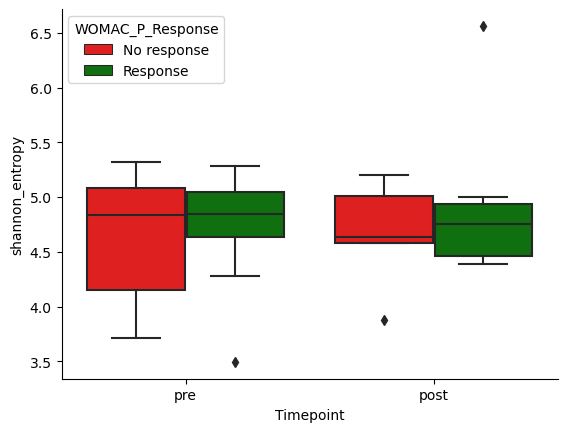

In [58]:
# 4 way paired boxplot trial
g = 'saliva'
df_alpha = g_to_dfd[g + '_adh']['alpha']

df_map = type_to_df_map[g].copy()
df_map = df_map.set_index('Together')
df_map = df_map[['Timepoint','WOMAC_P_Response']]

df_merge = pd.concat([df_alpha, df_map], axis=1)
df_merge = df_merge.dropna()

sns.boxplot(x='Timepoint', y='shannon_entropy',
            hue='WOMAC_P_Response', palette=["r", "g"],
            data=df_merge)
sns.despine()